# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos con ruido/Trayectorias 200 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')

In [6]:
np.shape(varftrain)

(7000, 10, 2, 200)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')

In [10]:
np.shape(varftest)

(2000, 10, 2, 200)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')

In [14]:
np.shape(varfval)

(1000, 10, 2, 200)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(10, 2, 200), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10, 2, 200)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(200, activation='tanh', kernel_initializer=HeNormal(
    ), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(100, activation='tanh', kernel_initializer=HeNormal(
    ), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='tanh', kernel_initializer=HeNormal(
    ), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=HeNormal(
    ), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation=custom_activation)])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 batch_normalization (BatchN  (None, 4000)             16000     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 200)               800200    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 100)               5100      
                                                        

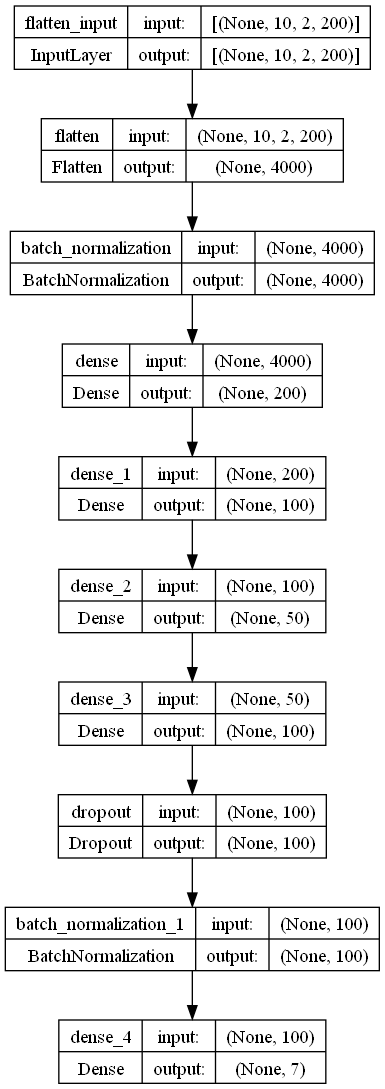

In [23]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [24]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [25]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [26]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [27]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [28]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [29]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 2s 13ms/step - loss: 25.9286 - a_1: 2.9511 - a_2: 2.9612 - b_1: 2.7685 - b_2: 2.7627 - d_1: 1.6631 - d_2: 1.6832 - n: 2.3693 - mean_metric: 0.5670 - val_loss: 22.0854 - val_a_1: 2.6744 - val_a_2: 2.8548 - val_b_1: 2.5409 - val_b_2: 2.7894 - val_d_1: 1.9547 - val_d_2: 1.7370 - val_n: 1.6064 - val_mean_metric: 0.5466 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 1s 9ms/step - loss: 20.0209 - a_1: 2.8660 - a_2: 2.8345 - b_1: 2.6155 - b_2: 2.6061 - d_1: 1.3832 - d_2: 1.4281 - n: 1.8011 - mean_metric: 0.5134 - val_loss: 16.8872 - val_a_1: 2.6985 - val_a_2: 2.7445 - val_b_1: 2.4457 - val_b_2: 2.5846 - val_d_1: 1.4116 - val_d_2: 1.4087 - val_n: 1.5162 - val_mean_metric: 0.5008 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 1s 9ms/step - loss: 16.0414 - a_1: 2.8121 - a_2: 2.7845 - b_1: 2.5536 - b_2: 2.5318 - d_1: 1.2496 - d_2: 1.2788 - n: 1.6784 - mean_metric: 0.4920 - val_loss: 13.7209 - val_a_1: 2.

70/70 [==============================] - 1s 9ms/step - loss: 7.7391 - a_1: 2.5429 - a_2: 2.5669 - b_1: 1.9199 - b_2: 1.9649 - d_1: 0.8011 - d_2: 0.8196 - n: 1.4949 - mean_metric: 0.4003 - val_loss: 7.6656 - val_a_1: 2.5222 - val_a_2: 2.5842 - val_b_1: 2.0214 - val_b_2: 1.9393 - val_d_1: 0.7426 - val_d_2: 0.8200 - val_n: 1.4990 - val_mean_metric: 0.4101 - lr: 0.0010
Epoch 23/1000
70/70 [==============================] - 1s 9ms/step - loss: 7.7325 - a_1: 2.5484 - a_2: 2.5585 - b_1: 1.9556 - b_2: 1.9965 - d_1: 0.7915 - d_2: 0.8378 - n: 1.4927 - mean_metric: 0.4026 - val_loss: 7.5828 - val_a_1: 2.5371 - val_a_2: 2.5813 - val_b_1: 1.8576 - val_b_2: 1.9354 - val_d_1: 0.9492 - val_d_2: 0.8995 - val_n: 1.4978 - val_mean_metric: 0.4146 - lr: 0.0010
Epoch 24/1000
70/70 [==============================] - 1s 9ms/step - loss: 7.5420 - a_1: 2.5468 - a_2: 2.5734 - b_1: 1.8932 - b_2: 1.9527 - d_1: 0.7942 - d_2: 0.8290 - n: 1.4908 - mean_metric: 0.3992 - val_loss: 7.4090 - val_a_1: 2.5189 - val_a_2: 2.

70/70 [==============================] - 1s 9ms/step - loss: 5.7711 - a_1: 2.4776 - a_2: 2.5099 - b_1: 1.7814 - b_2: 1.7196 - d_1: 0.6951 - d_2: 0.7057 - n: 1.4650 - mean_metric: 0.3752 - val_loss: 5.7889 - val_a_1: 2.5005 - val_a_2: 2.5558 - val_b_1: 1.8399 - val_b_2: 1.6954 - val_d_1: 0.7928 - val_d_2: 0.6227 - val_n: 1.4783 - val_mean_metric: 0.3883 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 1s 9ms/step - loss: 5.8660 - a_1: 2.4818 - a_2: 2.5097 - b_1: 1.8414 - b_2: 1.7397 - d_1: 0.7312 - d_2: 0.7230 - n: 1.4654 - mean_metric: 0.3798 - val_loss: 5.7460 - val_a_1: 2.4477 - val_a_2: 2.5455 - val_b_1: 1.8471 - val_b_2: 1.7738 - val_d_1: 0.6184 - val_d_2: 0.7426 - val_n: 1.4704 - val_mean_metric: 0.3870 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 1s 9ms/step - loss: 5.7796 - a_1: 2.4823 - a_2: 2.5177 - b_1: 1.8249 - b_2: 1.7225 - d_1: 0.7134 - d_2: 0.6922 - n: 1.4583 - mean_metric: 0.3771 - val_loss: 5.6276 - val_a_1: 2.4613 - val_a_2: 2.

70/70 [==============================] - 1s 9ms/step - loss: 5.0517 - a_1: 2.4580 - a_2: 2.4943 - b_1: 1.6792 - b_2: 1.5813 - d_1: 0.6603 - d_2: 0.6290 - n: 1.4580 - mean_metric: 0.3622 - val_loss: 4.9364 - val_a_1: 2.4496 - val_a_2: 2.5379 - val_b_1: 1.6585 - val_b_2: 1.5702 - val_d_1: 0.5891 - val_d_2: 0.5914 - val_n: 1.4648 - val_mean_metric: 0.3672 - lr: 0.0010
Epoch 65/1000
70/70 [==============================] - 1s 9ms/step - loss: 5.0792 - a_1: 2.4612 - a_2: 2.5024 - b_1: 1.7136 - b_2: 1.5961 - d_1: 0.6692 - d_2: 0.6598 - n: 1.4620 - mean_metric: 0.3656 - val_loss: 5.0352 - val_a_1: 2.4456 - val_a_2: 2.5391 - val_b_1: 1.6112 - val_b_2: 1.7157 - val_d_1: 0.5048 - val_d_2: 0.5707 - val_n: 1.4653 - val_mean_metric: 0.3670 - lr: 0.0010
Epoch 66/1000
70/70 [==============================] - 1s 9ms/step - loss: 5.0574 - a_1: 2.4578 - a_2: 2.4951 - b_1: 1.6801 - b_2: 1.5845 - d_1: 0.6610 - d_2: 0.6542 - n: 1.4572 - mean_metric: 0.3631 - val_loss: 4.8907 - val_a_1: 2.4466 - val_a_2: 2.

70/70 [==============================] - 1s 9ms/step - loss: 4.8233 - a_1: 2.4509 - a_2: 2.4727 - b_1: 1.6662 - b_2: 1.4946 - d_1: 0.6319 - d_2: 0.6192 - n: 1.4540 - mean_metric: 0.3566 - val_loss: 4.8466 - val_a_1: 2.4669 - val_a_2: 2.4913 - val_b_1: 1.7191 - val_b_2: 1.5069 - val_d_1: 0.6106 - val_d_2: 0.6063 - val_n: 1.4429 - val_mean_metric: 0.3666 - lr: 0.0010
Epoch 86/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.8390 - a_1: 2.4531 - a_2: 2.4814 - b_1: 1.6723 - b_2: 1.4850 - d_1: 0.6444 - d_2: 0.6155 - n: 1.4536 - mean_metric: 0.3570 - val_loss: 4.7020 - val_a_1: 2.4602 - val_a_2: 2.4941 - val_b_1: 1.6447 - val_b_2: 1.4517 - val_d_1: 0.5618 - val_d_2: 0.5157 - val_n: 1.4444 - val_mean_metric: 0.3574 - lr: 0.0010
Epoch 87/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.8278 - a_1: 2.4564 - a_2: 2.4836 - b_1: 1.6548 - b_2: 1.5192 - d_1: 0.6597 - d_2: 0.6074 - n: 1.4562 - mean_metric: 0.3582 - val_loss: 4.6604 - val_a_1: 2.4255 - val_a_2: 2.

70/70 [==============================] - 1s 9ms/step - loss: 4.6893 - a_1: 2.4448 - a_2: 2.4617 - b_1: 1.6398 - b_2: 1.4587 - d_1: 0.6404 - d_2: 0.6209 - n: 1.4508 - mean_metric: 0.3542 - val_loss: 4.5988 - val_a_1: 2.4530 - val_a_2: 2.4817 - val_b_1: 1.6312 - val_b_2: 1.4821 - val_d_1: 0.5275 - val_d_2: 0.5186 - val_n: 1.4429 - val_mean_metric: 0.3563 - lr: 0.0010
Epoch 107/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.6963 - a_1: 2.4423 - a_2: 2.4542 - b_1: 1.6418 - b_2: 1.4552 - d_1: 0.6464 - d_2: 0.6030 - n: 1.4479 - mean_metric: 0.3533 - val_loss: 4.6003 - val_a_1: 2.4276 - val_a_2: 2.5016 - val_b_1: 1.6163 - val_b_2: 1.4231 - val_d_1: 0.4939 - val_d_2: 0.5282 - val_n: 1.4397 - val_mean_metric: 0.3526 - lr: 0.0010
Epoch 108/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.6642 - a_1: 2.4373 - a_2: 2.4644 - b_1: 1.6127 - b_2: 1.4395 - d_1: 0.6252 - d_2: 0.5841 - n: 1.4487 - mean_metric: 0.3506 - val_loss: 4.5659 - val_a_1: 2.4548 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.6303 - a_1: 2.4429 - a_2: 2.4419 - b_1: 1.6076 - b_2: 1.4479 - d_1: 0.6267 - d_2: 0.6042 - n: 1.4493 - mean_metric: 0.3509 - val_loss: 4.4936 - val_a_1: 2.4264 - val_a_2: 2.4749 - val_b_1: 1.6184 - val_b_2: 1.4177 - val_d_1: 0.5251 - val_d_2: 0.4445 - val_n: 1.4461 - val_mean_metric: 0.3500 - lr: 0.0010
Epoch 128/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.5956 - a_1: 2.4301 - a_2: 2.4509 - b_1: 1.6153 - b_2: 1.4119 - d_1: 0.6238 - d_2: 0.6070 - n: 1.4449 - mean_metric: 0.3497 - val_loss: 4.4936 - val_a_1: 2.4267 - val_a_2: 2.4584 - val_b_1: 1.6129 - val_b_2: 1.4329 - val_d_1: 0.5864 - val_d_2: 0.4848 - val_n: 1.4470 - val_mean_metric: 0.3532 - lr: 0.0010
Epoch 129/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.5294 - a_1: 2.4312 - a_2: 2.4385 - b_1: 1.6116 - b_2: 1.3992 - d_1: 0.6093 - d_2: 0.5673 - n: 1.4465 - mean_metric: 0.3472 - val_loss: 4.4698 - val_a_1: 2.4188 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.5576 - a_1: 2.4382 - a_2: 2.4376 - b_1: 1.6000 - b_2: 1.4002 - d_1: 0.6264 - d_2: 0.5791 - n: 1.4455 - mean_metric: 0.3479 - val_loss: 4.4263 - val_a_1: 2.4330 - val_a_2: 2.4748 - val_b_1: 1.5517 - val_b_2: 1.3974 - val_d_1: 0.5037 - val_d_2: 0.4378 - val_n: 1.4361 - val_mean_metric: 0.3460 - lr: 0.0010
Epoch 149/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.5048 - a_1: 2.4360 - a_2: 2.4281 - b_1: 1.6018 - b_2: 1.3931 - d_1: 0.6084 - d_2: 0.5743 - n: 1.4454 - mean_metric: 0.3465 - val_loss: 4.5036 - val_a_1: 2.4513 - val_a_2: 2.4891 - val_b_1: 1.6407 - val_b_2: 1.4176 - val_d_1: 0.5530 - val_d_2: 0.4422 - val_n: 1.4366 - val_mean_metric: 0.3527 - lr: 0.0010
Epoch 150/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.5271 - a_1: 2.4358 - a_2: 2.4390 - b_1: 1.5973 - b_2: 1.3977 - d_1: 0.6367 - d_2: 0.5840 - n: 1.4462 - mean_metric: 0.3483 - val_loss: 4.5511 - val_a_1: 2.4368 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.4829 - a_1: 2.4479 - a_2: 2.4162 - b_1: 1.6064 - b_2: 1.3725 - d_1: 0.6293 - d_2: 0.5680 - n: 1.4388 - mean_metric: 0.3463 - val_loss: 4.4264 - val_a_1: 2.4238 - val_a_2: 2.4962 - val_b_1: 1.5988 - val_b_2: 1.3899 - val_d_1: 0.5257 - val_d_2: 0.5156 - val_n: 1.4365 - val_mean_metric: 0.3512 - lr: 0.0010
Epoch 170/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.4884 - a_1: 2.4287 - a_2: 2.4431 - b_1: 1.5862 - b_2: 1.3926 - d_1: 0.6008 - d_2: 0.5713 - n: 1.4463 - mean_metric: 0.3460 - val_loss: 4.4342 - val_a_1: 2.4275 - val_a_2: 2.4770 - val_b_1: 1.5581 - val_b_2: 1.4153 - val_d_1: 0.5056 - val_d_2: 0.4168 - val_n: 1.4332 - val_mean_metric: 0.3460 - lr: 0.0010
Epoch 171/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.5028 - a_1: 2.4356 - a_2: 2.4139 - b_1: 1.5835 - b_2: 1.3940 - d_1: 0.6242 - d_2: 0.5980 - n: 1.4447 - mean_metric: 0.3468 - val_loss: 4.4855 - val_a_1: 2.4194 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.4463 - a_1: 2.4323 - a_2: 2.4246 - b_1: 1.5829 - b_2: 1.3590 - d_1: 0.6237 - d_2: 0.5707 - n: 1.4459 - mean_metric: 0.3450 - val_loss: 4.3760 - val_a_1: 2.4136 - val_a_2: 2.4755 - val_b_1: 1.5864 - val_b_2: 1.3500 - val_d_1: 0.5669 - val_d_2: 0.4378 - val_n: 1.4365 - val_mean_metric: 0.3470 - lr: 0.0010
Epoch 191/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.4357 - a_1: 2.4260 - a_2: 2.4118 - b_1: 1.5897 - b_2: 1.3572 - d_1: 0.6171 - d_2: 0.5763 - n: 1.4407 - mean_metric: 0.3444 - val_loss: 4.3591 - val_a_1: 2.4182 - val_a_2: 2.4585 - val_b_1: 1.6043 - val_b_2: 1.3591 - val_d_1: 0.4868 - val_d_2: 0.4694 - val_n: 1.4293 - val_mean_metric: 0.3457 - lr: 0.0010
Epoch 192/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.4316 - a_1: 2.4243 - a_2: 2.4182 - b_1: 1.6127 - b_2: 1.3462 - d_1: 0.6255 - d_2: 0.5595 - n: 1.4406 - mean_metric: 0.3446 - val_loss: 4.4544 - val_a_1: 2.4086 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.3639 - a_1: 2.4205 - a_2: 2.3995 - b_1: 1.5585 - b_2: 1.3306 - d_1: 0.6290 - d_2: 0.5542 - n: 1.4395 - mean_metric: 0.3414 - val_loss: 4.4527 - val_a_1: 2.4377 - val_a_2: 2.4751 - val_b_1: 1.5555 - val_b_2: 1.4915 - val_d_1: 0.4737 - val_d_2: 0.4261 - val_n: 1.4248 - val_mean_metric: 0.3478 - lr: 0.0010
Epoch 212/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.4189 - a_1: 2.4252 - a_2: 2.4127 - b_1: 1.5800 - b_2: 1.3697 - d_1: 0.6039 - d_2: 0.5664 - n: 1.4455 - mean_metric: 0.3438 - val_loss: 4.3397 - val_a_1: 2.4098 - val_a_2: 2.4637 - val_b_1: 1.5694 - val_b_2: 1.3401 - val_d_1: 0.5317 - val_d_2: 0.4015 - val_n: 1.4296 - val_mean_metric: 0.3431 - lr: 0.0010
Epoch 213/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.4044 - a_1: 2.4130 - a_2: 2.4132 - b_1: 1.5737 - b_2: 1.3609 - d_1: 0.6035 - d_2: 0.5712 - n: 1.4410 - mean_metric: 0.3430 - val_loss: 4.3809 - val_a_1: 2.4204 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.3283 - a_1: 2.4121 - a_2: 2.3897 - b_1: 1.5565 - b_2: 1.3519 - d_1: 0.5826 - d_2: 0.5529 - n: 1.4314 - mean_metric: 0.3395 - val_loss: 4.2979 - val_a_1: 2.4146 - val_a_2: 2.4646 - val_b_1: 1.5196 - val_b_2: 1.3403 - val_d_1: 0.4799 - val_d_2: 0.4327 - val_n: 1.4259 - val_mean_metric: 0.3407 - lr: 0.0010
Epoch 233/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.3644 - a_1: 2.4238 - a_2: 2.3881 - b_1: 1.5408 - b_2: 1.3547 - d_1: 0.5873 - d_2: 0.5537 - n: 1.4326 - mean_metric: 0.3397 - val_loss: 4.3422 - val_a_1: 2.3965 - val_a_2: 2.4519 - val_b_1: 1.5265 - val_b_2: 1.3730 - val_d_1: 0.4647 - val_d_2: 0.4261 - val_n: 1.4196 - val_mean_metric: 0.3401 - lr: 0.0010
Epoch 234/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.3977 - a_1: 2.4202 - a_2: 2.4038 - b_1: 1.5604 - b_2: 1.3477 - d_1: 0.6154 - d_2: 0.5543 - n: 1.4374 - mean_metric: 0.3417 - val_loss: 4.4509 - val_a_1: 2.4106 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.3486 - a_1: 2.4222 - a_2: 2.4251 - b_1: 1.5259 - b_2: 1.3466 - d_1: 0.5768 - d_2: 0.5708 - n: 1.4332 - mean_metric: 0.3404 - val_loss: 4.3263 - val_a_1: 2.4056 - val_a_2: 2.4911 - val_b_1: 1.5083 - val_b_2: 1.4318 - val_d_1: 0.4615 - val_d_2: 0.4502 - val_n: 1.4248 - val_mean_metric: 0.3439 - lr: 0.0010
Epoch 254/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.3327 - a_1: 2.4153 - a_2: 2.3828 - b_1: 1.5315 - b_2: 1.3592 - d_1: 0.5957 - d_2: 0.5575 - n: 1.4301 - mean_metric: 0.3394 - val_loss: 4.3651 - val_a_1: 2.4023 - val_a_2: 2.4575 - val_b_1: 1.5150 - val_b_2: 1.3633 - val_d_1: 0.5393 - val_d_2: 0.4625 - val_n: 1.4198 - val_mean_metric: 0.3436 - lr: 0.0010
Epoch 255/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.3347 - a_1: 2.4179 - a_2: 2.3924 - b_1: 1.5252 - b_2: 1.3350 - d_1: 0.5886 - d_2: 0.5616 - n: 1.4244 - mean_metric: 0.3386 - val_loss: 4.4597 - val_a_1: 2.4017 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.3071 - a_1: 2.4006 - a_2: 2.3940 - b_1: 1.5283 - b_2: 1.3125 - d_1: 0.5845 - d_2: 0.5569 - n: 1.4349 - mean_metric: 0.3375 - val_loss: 4.2809 - val_a_1: 2.3883 - val_a_2: 2.4372 - val_b_1: 1.5125 - val_b_2: 1.3916 - val_d_1: 0.5179 - val_d_2: 0.3908 - val_n: 1.4209 - val_mean_metric: 0.3401 - lr: 0.0010
Epoch 275/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.3378 - a_1: 2.4073 - a_2: 2.4003 - b_1: 1.5460 - b_2: 1.3225 - d_1: 0.5918 - d_2: 0.5629 - n: 1.4277 - mean_metric: 0.3390 - val_loss: 4.2618 - val_a_1: 2.3882 - val_a_2: 2.4378 - val_b_1: 1.5139 - val_b_2: 1.3116 - val_d_1: 0.4855 - val_d_2: 0.4228 - val_n: 1.4260 - val_mean_metric: 0.3376 - lr: 0.0010
Epoch 276/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.3346 - a_1: 2.4102 - a_2: 2.3948 - b_1: 1.5329 - b_2: 1.3490 - d_1: 0.5743 - d_2: 0.5544 - n: 1.4290 - mean_metric: 0.3385 - val_loss: 4.2632 - val_a_1: 2.3737 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.2910 - a_1: 2.3984 - a_2: 2.3799 - b_1: 1.5078 - b_2: 1.3331 - d_1: 0.5809 - d_2: 0.5625 - n: 1.4250 - mean_metric: 0.3366 - val_loss: 4.3257 - val_a_1: 2.3995 - val_a_2: 2.4409 - val_b_1: 1.5958 - val_b_2: 1.4001 - val_d_1: 0.4493 - val_d_2: 0.4147 - val_n: 1.4160 - val_mean_metric: 0.3420 - lr: 0.0010
Epoch 296/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.3007 - a_1: 2.4234 - a_2: 2.3785 - b_1: 1.5301 - b_2: 1.3082 - d_1: 0.5899 - d_2: 0.5617 - n: 1.4278 - mean_metric: 0.3378 - val_loss: 4.2895 - val_a_1: 2.3862 - val_a_2: 2.4350 - val_b_1: 1.5081 - val_b_2: 1.3624 - val_d_1: 0.5043 - val_d_2: 0.4439 - val_n: 1.4175 - val_mean_metric: 0.3400 - lr: 0.0010
Epoch 297/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.2672 - a_1: 2.3946 - a_2: 2.3801 - b_1: 1.5219 - b_2: 1.3162 - d_1: 0.5644 - d_2: 0.5562 - n: 1.4265 - mean_metric: 0.3358 - val_loss: 4.2459 - val_a_1: 2.3797 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.2636 - a_1: 2.3957 - a_2: 2.3745 - b_1: 1.4936 - b_2: 1.3146 - d_1: 0.5875 - d_2: 0.5507 - n: 1.4303 - mean_metric: 0.3353 - val_loss: 4.3404 - val_a_1: 2.4062 - val_a_2: 2.4581 - val_b_1: 1.5071 - val_b_2: 1.3376 - val_d_1: 0.5325 - val_d_2: 0.4612 - val_n: 1.4322 - val_mean_metric: 0.3426 - lr: 0.0010
Epoch 317/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.2589 - a_1: 2.4028 - a_2: 2.3725 - b_1: 1.4966 - b_2: 1.3170 - d_1: 0.5849 - d_2: 0.5415 - n: 1.4276 - mean_metric: 0.3353 - val_loss: 4.2790 - val_a_1: 2.3881 - val_a_2: 2.4681 - val_b_1: 1.4823 - val_b_2: 1.3608 - val_d_1: 0.5507 - val_d_2: 0.3920 - val_n: 1.4211 - val_mean_metric: 0.3402 - lr: 0.0010
Epoch 318/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.2276 - a_1: 2.4009 - a_2: 2.3667 - b_1: 1.5048 - b_2: 1.3051 - d_1: 0.5739 - d_2: 0.5425 - n: 1.4203 - mean_metric: 0.3342 - val_loss: 4.2187 - val_a_1: 2.3699 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.2580 - a_1: 2.4058 - a_2: 2.3767 - b_1: 1.5047 - b_2: 1.2996 - d_1: 0.5614 - d_2: 0.5529 - n: 1.4234 - mean_metric: 0.3346 - val_loss: 4.2979 - val_a_1: 2.3852 - val_a_2: 2.4410 - val_b_1: 1.5032 - val_b_2: 1.3513 - val_d_1: 0.5957 - val_d_2: 0.4064 - val_n: 1.4171 - val_mean_metric: 0.3414 - lr: 0.0010
Epoch 338/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.2371 - a_1: 2.3897 - a_2: 2.3721 - b_1: 1.4979 - b_2: 1.2837 - d_1: 0.5812 - d_2: 0.5352 - n: 1.4266 - mean_metric: 0.3333 - val_loss: 4.2314 - val_a_1: 2.3846 - val_a_2: 2.4427 - val_b_1: 1.4912 - val_b_2: 1.3360 - val_d_1: 0.4283 - val_d_2: 0.3932 - val_n: 1.4156 - val_mean_metric: 0.3344 - lr: 0.0010
Epoch 339/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.2694 - a_1: 2.4086 - a_2: 2.3809 - b_1: 1.5094 - b_2: 1.3097 - d_1: 0.5844 - d_2: 0.5464 - n: 1.4257 - mean_metric: 0.3360 - val_loss: 4.2411 - val_a_1: 2.3816 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.2168 - a_1: 2.3987 - a_2: 2.3742 - b_1: 1.4743 - b_2: 1.3028 - d_1: 0.5564 - d_2: 0.5374 - n: 1.4225 - mean_metric: 0.3327 - val_loss: 4.2168 - val_a_1: 2.3790 - val_a_2: 2.4226 - val_b_1: 1.4742 - val_b_2: 1.3414 - val_d_1: 0.4451 - val_d_2: 0.4095 - val_n: 1.4123 - val_mean_metric: 0.3341 - lr: 0.0010
Epoch 359/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.2380 - a_1: 2.3938 - a_2: 2.3788 - b_1: 1.4740 - b_2: 1.3223 - d_1: 0.5473 - d_2: 0.5517 - n: 1.4229 - mean_metric: 0.3334 - val_loss: 4.2691 - val_a_1: 2.3666 - val_a_2: 2.4547 - val_b_1: 1.5046 - val_b_2: 1.3797 - val_d_1: 0.5293 - val_d_2: 0.4176 - val_n: 1.4279 - val_mean_metric: 0.3408 - lr: 0.0010
Epoch 360/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.2351 - a_1: 2.3882 - a_2: 2.3693 - b_1: 1.4861 - b_2: 1.3131 - d_1: 0.5668 - d_2: 0.5543 - n: 1.4265 - mean_metric: 0.3339 - val_loss: 4.2391 - val_a_1: 2.3802 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.1855 - a_1: 2.3970 - a_2: 2.3589 - b_1: 1.4531 - b_2: 1.2909 - d_1: 0.5533 - d_2: 0.5455 - n: 1.4279 - mean_metric: 0.3313 - val_loss: 4.1898 - val_a_1: 2.3650 - val_a_2: 2.4345 - val_b_1: 1.4302 - val_b_2: 1.3319 - val_d_1: 0.4900 - val_d_2: 0.4593 - val_n: 1.4165 - val_mean_metric: 0.3355 - lr: 0.0010
Epoch 380/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.1812 - a_1: 2.3865 - a_2: 2.3671 - b_1: 1.4572 - b_2: 1.3058 - d_1: 0.5554 - d_2: 0.5513 - n: 1.4190 - mean_metric: 0.3318 - val_loss: 4.1752 - val_a_1: 2.3559 - val_a_2: 2.4225 - val_b_1: 1.4362 - val_b_2: 1.3441 - val_d_1: 0.4791 - val_d_2: 0.3999 - val_n: 1.4094 - val_mean_metric: 0.3328 - lr: 0.0010
Epoch 381/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.1948 - a_1: 2.3853 - a_2: 2.3678 - b_1: 1.4676 - b_2: 1.3054 - d_1: 0.5568 - d_2: 0.5692 - n: 1.4210 - mean_metric: 0.3328 - val_loss: 4.1785 - val_a_1: 2.3734 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.1987 - a_1: 2.3966 - a_2: 2.3650 - b_1: 1.4621 - b_2: 1.2923 - d_1: 0.5620 - d_2: 0.5426 - n: 1.4176 - mean_metric: 0.3318 - val_loss: 4.3308 - val_a_1: 2.3953 - val_a_2: 2.4414 - val_b_1: 1.5291 - val_b_2: 1.3698 - val_d_1: 0.5110 - val_d_2: 0.4839 - val_n: 1.4096 - val_mean_metric: 0.3428 - lr: 0.0010
Epoch 401/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.1885 - a_1: 2.3882 - a_2: 2.3607 - b_1: 1.4604 - b_2: 1.2955 - d_1: 0.5796 - d_2: 0.5456 - n: 1.4184 - mean_metric: 0.3320 - val_loss: 4.1974 - val_a_1: 2.3631 - val_a_2: 2.4294 - val_b_1: 1.4886 - val_b_2: 1.3352 - val_d_1: 0.5122 - val_d_2: 0.3989 - val_n: 1.4016 - val_mean_metric: 0.3356 - lr: 0.0010
Epoch 402/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.1932 - a_1: 2.4067 - a_2: 2.3583 - b_1: 1.4645 - b_2: 1.2951 - d_1: 0.5858 - d_2: 0.5499 - n: 1.4224 - mean_metric: 0.3332 - val_loss: 4.2688 - val_a_1: 2.3983 - val_a_2: 

70/70 [==============================] - 1s 9ms/step - loss: 4.2134 - a_1: 2.3951 - a_2: 2.3645 - b_1: 1.4525 - b_2: 1.3182 - d_1: 0.5528 - d_2: 0.5589 - n: 1.4226 - mean_metric: 0.3327 - val_loss: 4.3601 - val_a_1: 2.4207 - val_a_2: 2.4596 - val_b_1: 1.4861 - val_b_2: 1.4178 - val_d_1: 0.4728 - val_d_2: 0.4653 - val_n: 1.4194 - val_mean_metric: 0.3427 - lr: 9.6700e-04
Epoch 422/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.1800 - a_1: 2.3851 - a_2: 2.3577 - b_1: 1.4490 - b_2: 1.2979 - d_1: 0.5561 - d_2: 0.5596 - n: 1.4176 - mean_metric: 0.3312 - val_loss: 4.2229 - val_a_1: 2.3885 - val_a_2: 2.4418 - val_b_1: 1.4434 - val_b_2: 1.3485 - val_d_1: 0.4336 - val_d_2: 0.4037 - val_n: 1.4112 - val_mean_metric: 0.3337 - lr: 9.6535e-04
Epoch 423/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.1733 - a_1: 2.3831 - a_2: 2.3655 - b_1: 1.4281 - b_2: 1.3004 - d_1: 0.5561 - d_2: 0.5620 - n: 1.4191 - mean_metric: 0.3309 - val_loss: 4.2319 - val_a_1: 2.3960 - v

70/70 [==============================] - 1s 9ms/step - loss: 4.0934 - a_1: 2.3647 - a_2: 2.3487 - b_1: 1.4082 - b_2: 1.2765 - d_1: 0.5495 - d_2: 0.5364 - n: 1.4139 - mean_metric: 0.3271 - val_loss: 4.1767 - val_a_1: 2.3720 - val_a_2: 2.4260 - val_b_1: 1.4063 - val_b_2: 1.3283 - val_d_1: 0.4528 - val_d_2: 0.4044 - val_n: 1.4008 - val_mean_metric: 0.3310 - lr: 9.3235e-04
Epoch 443/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.1209 - a_1: 2.3764 - a_2: 2.3503 - b_1: 1.4058 - b_2: 1.2978 - d_1: 0.5461 - d_2: 0.5441 - n: 1.4154 - mean_metric: 0.3284 - val_loss: 4.1856 - val_a_1: 2.3859 - val_a_2: 2.4271 - val_b_1: 1.4485 - val_b_2: 1.3043 - val_d_1: 0.4422 - val_d_2: 0.4318 - val_n: 1.4065 - val_mean_metric: 0.3328 - lr: 9.3070e-04
Epoch 444/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.1156 - a_1: 2.3862 - a_2: 2.3585 - b_1: 1.4103 - b_2: 1.2733 - d_1: 0.5494 - d_2: 0.5479 - n: 1.4129 - mean_metric: 0.3284 - val_loss: 4.1055 - val_a_1: 2.3812 - v

70/70 [==============================] - 1s 9ms/step - loss: 4.0713 - a_1: 2.3633 - a_2: 2.3416 - b_1: 1.4010 - b_2: 1.2577 - d_1: 0.5336 - d_2: 0.5198 - n: 1.4190 - mean_metric: 0.3250 - val_loss: 4.1815 - val_a_1: 2.3687 - val_a_2: 2.4201 - val_b_1: 1.4197 - val_b_2: 1.3436 - val_d_1: 0.4872 - val_d_2: 0.4437 - val_n: 1.3964 - val_mean_metric: 0.3339 - lr: 8.9770e-04
Epoch 464/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.0919 - a_1: 2.3800 - a_2: 2.3462 - b_1: 1.3917 - b_2: 1.2698 - d_1: 0.5425 - d_2: 0.5422 - n: 1.4143 - mean_metric: 0.3267 - val_loss: 4.1733 - val_a_1: 2.3648 - val_a_2: 2.4358 - val_b_1: 1.4205 - val_b_2: 1.3399 - val_d_1: 0.4961 - val_d_2: 0.4277 - val_n: 1.4060 - val_mean_metric: 0.3343 - lr: 8.9605e-04
Epoch 465/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.0946 - a_1: 2.3771 - a_2: 2.3538 - b_1: 1.3917 - b_2: 1.2793 - d_1: 0.5538 - d_2: 0.5516 - n: 1.4067 - mean_metric: 0.3276 - val_loss: 4.1824 - val_a_1: 2.3741 - v

70/70 [==============================] - 1s 9ms/step - loss: 4.0550 - a_1: 2.3553 - a_2: 2.3464 - b_1: 1.3585 - b_2: 1.2915 - d_1: 0.5293 - d_2: 0.5490 - n: 1.4080 - mean_metric: 0.3251 - val_loss: 4.1136 - val_a_1: 2.3583 - val_a_2: 2.4354 - val_b_1: 1.3537 - val_b_2: 1.3353 - val_d_1: 0.4706 - val_d_2: 0.3961 - val_n: 1.4026 - val_mean_metric: 0.3296 - lr: 8.6305e-04
Epoch 485/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.0271 - a_1: 2.3690 - a_2: 2.3432 - b_1: 1.3521 - b_2: 1.2469 - d_1: 0.5270 - d_2: 0.5345 - n: 1.4070 - mean_metric: 0.3232 - val_loss: 4.1134 - val_a_1: 2.3611 - val_a_2: 2.4480 - val_b_1: 1.3708 - val_b_2: 1.3061 - val_d_1: 0.4978 - val_d_2: 0.4028 - val_n: 1.4017 - val_mean_metric: 0.3308 - lr: 8.6140e-04
Epoch 486/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.0694 - a_1: 2.3726 - a_2: 2.3607 - b_1: 1.3667 - b_2: 1.2878 - d_1: 0.5433 - d_2: 0.5340 - n: 1.4076 - mean_metric: 0.3263 - val_loss: 4.1380 - val_a_1: 2.3447 - v

70/70 [==============================] - 1s 9ms/step - loss: 4.0321 - a_1: 2.3661 - a_2: 2.3408 - b_1: 1.3748 - b_2: 1.2676 - d_1: 0.5350 - d_2: 0.5383 - n: 1.4090 - mean_metric: 0.3248 - val_loss: 4.0561 - val_a_1: 2.3597 - val_a_2: 2.4224 - val_b_1: 1.3536 - val_b_2: 1.2900 - val_d_1: 0.4256 - val_d_2: 0.4319 - val_n: 1.4089 - val_mean_metric: 0.3276 - lr: 8.2840e-04
Epoch 506/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.9977 - a_1: 2.3562 - a_2: 2.3207 - b_1: 1.3574 - b_2: 1.2720 - d_1: 0.5332 - d_2: 0.5303 - n: 1.4056 - mean_metric: 0.3230 - val_loss: 4.1467 - val_a_1: 2.3742 - val_a_2: 2.4268 - val_b_1: 1.4351 - val_b_2: 1.2971 - val_d_1: 0.4206 - val_d_2: 0.4013 - val_n: 1.3890 - val_mean_metric: 0.3294 - lr: 8.2675e-04
Epoch 507/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.0170 - a_1: 2.3555 - a_2: 2.3469 - b_1: 1.3702 - b_2: 1.2542 - d_1: 0.5515 - d_2: 0.5321 - n: 1.4101 - mean_metric: 0.3245 - val_loss: 4.0876 - val_a_1: 2.3657 - v

70/70 [==============================] - 1s 9ms/step - loss: 4.0172 - a_1: 2.3526 - a_2: 2.3508 - b_1: 1.3457 - b_2: 1.2729 - d_1: 0.5500 - d_2: 0.5323 - n: 1.4060 - mean_metric: 0.3242 - val_loss: 4.0887 - val_a_1: 2.3485 - val_a_2: 2.4361 - val_b_1: 1.3496 - val_b_2: 1.2780 - val_d_1: 0.4449 - val_d_2: 0.4016 - val_n: 1.4060 - val_mean_metric: 0.3267 - lr: 7.9375e-04
Epoch 527/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.0090 - a_1: 2.3481 - a_2: 2.3544 - b_1: 1.3596 - b_2: 1.2508 - d_1: 0.5393 - d_2: 0.5253 - n: 1.4142 - mean_metric: 0.3236 - val_loss: 4.1471 - val_a_1: 2.3556 - val_a_2: 2.4197 - val_b_1: 1.4474 - val_b_2: 1.3005 - val_d_1: 0.4222 - val_d_2: 0.4170 - val_n: 1.4002 - val_mean_metric: 0.3299 - lr: 7.9210e-04
Epoch 528/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.9922 - a_1: 2.3449 - a_2: 2.3514 - b_1: 1.3245 - b_2: 1.2674 - d_1: 0.5405 - d_2: 0.5258 - n: 1.4040 - mean_metric: 0.3225 - val_loss: 4.0523 - val_a_1: 2.3391 - v

70/70 [==============================] - 1s 9ms/step - loss: 4.0140 - a_1: 2.3609 - a_2: 2.3428 - b_1: 1.3538 - b_2: 1.2629 - d_1: 0.5522 - d_2: 0.5193 - n: 1.4076 - mean_metric: 0.3238 - val_loss: 4.1064 - val_a_1: 2.3741 - val_a_2: 2.4210 - val_b_1: 1.3879 - val_b_2: 1.2864 - val_d_1: 0.4325 - val_d_2: 0.3934 - val_n: 1.3947 - val_mean_metric: 0.3275 - lr: 7.5910e-04
Epoch 548/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.9955 - a_1: 2.3578 - a_2: 2.3347 - b_1: 1.3594 - b_2: 1.2506 - d_1: 0.5479 - d_2: 0.5326 - n: 1.4117 - mean_metric: 0.3237 - val_loss: 4.0600 - val_a_1: 2.3599 - val_a_2: 2.4314 - val_b_1: 1.4012 - val_b_2: 1.2742 - val_d_1: 0.4210 - val_d_2: 0.3854 - val_n: 1.4001 - val_mean_metric: 0.3269 - lr: 7.5745e-04
Epoch 549/1000
70/70 [==============================] - 1s 9ms/step - loss: 4.0035 - a_1: 2.3575 - a_2: 2.3409 - b_1: 1.3433 - b_2: 1.2683 - d_1: 0.5537 - d_2: 0.5301 - n: 1.4123 - mean_metric: 0.3241 - val_loss: 4.0089 - val_a_1: 2.3523 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.9489 - a_1: 2.3463 - a_2: 2.3281 - b_1: 1.3427 - b_2: 1.2547 - d_1: 0.5252 - d_2: 0.5285 - n: 1.4005 - mean_metric: 0.3214 - val_loss: 4.0531 - val_a_1: 2.3457 - val_a_2: 2.4303 - val_b_1: 1.3497 - val_b_2: 1.3176 - val_d_1: 0.4076 - val_d_2: 0.3937 - val_n: 1.3861 - val_mean_metric: 0.3255 - lr: 7.2445e-04
Epoch 569/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.9633 - a_1: 2.3481 - a_2: 2.3384 - b_1: 1.3354 - b_2: 1.2611 - d_1: 0.5108 - d_2: 0.5273 - n: 1.4105 - mean_metric: 0.3216 - val_loss: 4.0778 - val_a_1: 2.3593 - val_a_2: 2.4322 - val_b_1: 1.3814 - val_b_2: 1.2691 - val_d_1: 0.4461 - val_d_2: 0.4031 - val_n: 1.3974 - val_mean_metric: 0.3275 - lr: 7.2280e-04
Epoch 570/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.9588 - a_1: 2.3538 - a_2: 2.3181 - b_1: 1.3261 - b_2: 1.2618 - d_1: 0.5407 - d_2: 0.5373 - n: 1.4030 - mean_metric: 0.3219 - val_loss: 4.0455 - val_a_1: 2.3686 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.9083 - a_1: 2.3409 - a_2: 2.3195 - b_1: 1.3039 - b_2: 1.2503 - d_1: 0.5111 - d_2: 0.5256 - n: 1.4026 - mean_metric: 0.3190 - val_loss: 4.0162 - val_a_1: 2.3403 - val_a_2: 2.4339 - val_b_1: 1.3438 - val_b_2: 1.2778 - val_d_1: 0.4124 - val_d_2: 0.4041 - val_n: 1.4010 - val_mean_metric: 0.3249 - lr: 6.8980e-04
Epoch 590/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.9203 - a_1: 2.3559 - a_2: 2.3187 - b_1: 1.3297 - b_2: 1.2393 - d_1: 0.5289 - d_2: 0.5265 - n: 1.4083 - mean_metric: 0.3208 - val_loss: 4.0434 - val_a_1: 2.3519 - val_a_2: 2.4309 - val_b_1: 1.3767 - val_b_2: 1.2972 - val_d_1: 0.4359 - val_d_2: 0.3978 - val_n: 1.4070 - val_mean_metric: 0.3277 - lr: 6.8815e-04
Epoch 591/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.9341 - a_1: 2.3472 - a_2: 2.3241 - b_1: 1.3282 - b_2: 1.2450 - d_1: 0.5173 - d_2: 0.5241 - n: 1.4128 - mean_metric: 0.3205 - val_loss: 4.0104 - val_a_1: 2.3473 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.9167 - a_1: 2.3442 - a_2: 2.3260 - b_1: 1.3105 - b_2: 1.2545 - d_1: 0.5051 - d_2: 0.5328 - n: 1.4073 - mean_metric: 0.3199 - val_loss: 3.9991 - val_a_1: 2.3472 - val_a_2: 2.4197 - val_b_1: 1.3536 - val_b_2: 1.2481 - val_d_1: 0.4187 - val_d_2: 0.4011 - val_n: 1.3964 - val_mean_metric: 0.3239 - lr: 6.5515e-04
Epoch 611/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.9219 - a_1: 2.3367 - a_2: 2.3267 - b_1: 1.3008 - b_2: 1.2682 - d_1: 0.5244 - d_2: 0.5210 - n: 1.4066 - mean_metric: 0.3200 - val_loss: 4.0221 - val_a_1: 2.3520 - val_a_2: 2.4299 - val_b_1: 1.3725 - val_b_2: 1.2802 - val_d_1: 0.3927 - val_d_2: 0.3960 - val_n: 1.3975 - val_mean_metric: 0.3252 - lr: 6.5350e-04
Epoch 612/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.9161 - a_1: 2.3370 - a_2: 2.3211 - b_1: 1.3211 - b_2: 1.2353 - d_1: 0.5242 - d_2: 0.5157 - n: 1.4081 - mean_metric: 0.3193 - val_loss: 4.0586 - val_a_1: 2.3558 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.8997 - a_1: 2.3254 - a_2: 2.3248 - b_1: 1.3022 - b_2: 1.2577 - d_1: 0.5212 - d_2: 0.5199 - n: 1.4042 - mean_metric: 0.3191 - val_loss: 4.0415 - val_a_1: 2.3511 - val_a_2: 2.4364 - val_b_1: 1.3485 - val_b_2: 1.2497 - val_d_1: 0.4032 - val_d_2: 0.4150 - val_n: 1.3981 - val_mean_metric: 0.3245 - lr: 6.2050e-04
Epoch 632/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.8753 - a_1: 2.3376 - a_2: 2.3291 - b_1: 1.2923 - b_2: 1.2392 - d_1: 0.5161 - d_2: 0.5170 - n: 1.4019 - mean_metric: 0.3183 - val_loss: 3.9621 - val_a_1: 2.3400 - val_a_2: 2.4232 - val_b_1: 1.3074 - val_b_2: 1.2886 - val_d_1: 0.4056 - val_d_2: 0.3756 - val_n: 1.3985 - val_mean_metric: 0.3224 - lr: 6.1885e-04
Epoch 633/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.9055 - a_1: 2.3439 - a_2: 2.3264 - b_1: 1.3121 - b_2: 1.2530 - d_1: 0.5171 - d_2: 0.5317 - n: 1.4042 - mean_metric: 0.3202 - val_loss: 4.0644 - val_a_1: 2.3451 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.8609 - a_1: 2.3192 - a_2: 2.3001 - b_1: 1.3032 - b_2: 1.2565 - d_1: 0.5178 - d_2: 0.5101 - n: 1.4040 - mean_metric: 0.3176 - val_loss: 4.0165 - val_a_1: 2.3501 - val_a_2: 2.4399 - val_b_1: 1.3804 - val_b_2: 1.2566 - val_d_1: 0.4416 - val_d_2: 0.3855 - val_n: 1.3864 - val_mean_metric: 0.3258 - lr: 5.8585e-04
Epoch 653/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.8781 - a_1: 2.3282 - a_2: 2.3183 - b_1: 1.3077 - b_2: 1.2424 - d_1: 0.5188 - d_2: 0.5149 - n: 1.3999 - mean_metric: 0.3183 - val_loss: 4.0051 - val_a_1: 2.3531 - val_a_2: 2.4322 - val_b_1: 1.3668 - val_b_2: 1.2495 - val_d_1: 0.3912 - val_d_2: 0.3813 - val_n: 1.3914 - val_mean_metric: 0.3233 - lr: 5.8420e-04
Epoch 654/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.8516 - a_1: 2.3251 - a_2: 2.3190 - b_1: 1.2789 - b_2: 1.2319 - d_1: 0.5227 - d_2: 0.5132 - n: 1.4043 - mean_metric: 0.3171 - val_loss: 4.0153 - val_a_1: 2.3670 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.8524 - a_1: 2.3218 - a_2: 2.3185 - b_1: 1.2811 - b_2: 1.2607 - d_1: 0.5101 - d_2: 0.5246 - n: 1.4076 - mean_metric: 0.3181 - val_loss: 3.9938 - val_a_1: 2.3470 - val_a_2: 2.4308 - val_b_1: 1.3405 - val_b_2: 1.2565 - val_d_1: 0.3934 - val_d_2: 0.3954 - val_n: 1.3977 - val_mean_metric: 0.3231 - lr: 5.5120e-04
Epoch 674/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.8572 - a_1: 2.3338 - a_2: 2.2946 - b_1: 1.3031 - b_2: 1.2432 - d_1: 0.5226 - d_2: 0.5125 - n: 1.4026 - mean_metric: 0.3177 - val_loss: 4.0341 - val_a_1: 2.3693 - val_a_2: 2.4430 - val_b_1: 1.3584 - val_b_2: 1.2724 - val_d_1: 0.4161 - val_d_2: 0.4024 - val_n: 1.3997 - val_mean_metric: 0.3265 - lr: 5.4955e-04
Epoch 675/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.8457 - a_1: 2.3175 - a_2: 2.3164 - b_1: 1.2978 - b_2: 1.2280 - d_1: 0.5142 - d_2: 0.5146 - n: 1.4042 - mean_metric: 0.3170 - val_loss: 3.9540 - val_a_1: 2.3279 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.8635 - a_1: 2.3136 - a_2: 2.3198 - b_1: 1.2821 - b_2: 1.2438 - d_1: 0.5223 - d_2: 0.5182 - n: 1.4052 - mean_metric: 0.3175 - val_loss: 3.9561 - val_a_1: 2.3403 - val_a_2: 2.4347 - val_b_1: 1.3099 - val_b_2: 1.2701 - val_d_1: 0.3967 - val_d_2: 0.3815 - val_n: 1.3912 - val_mean_metric: 0.3219 - lr: 5.1655e-04
Epoch 695/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.8325 - a_1: 2.3226 - a_2: 2.3032 - b_1: 1.2682 - b_2: 1.2353 - d_1: 0.5229 - d_2: 0.5112 - n: 1.4104 - mean_metric: 0.3163 - val_loss: 3.9804 - val_a_1: 2.3494 - val_a_2: 2.4354 - val_b_1: 1.3128 - val_b_2: 1.2424 - val_d_1: 0.3912 - val_d_2: 0.3895 - val_n: 1.3926 - val_mean_metric: 0.3216 - lr: 5.1490e-04
Epoch 696/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.8281 - a_1: 2.3215 - a_2: 2.3088 - b_1: 1.2756 - b_2: 1.2436 - d_1: 0.5095 - d_2: 0.5046 - n: 1.3966 - mean_metric: 0.3160 - val_loss: 3.9587 - val_a_1: 2.3324 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.8074 - a_1: 2.3165 - a_2: 2.2931 - b_1: 1.2886 - b_2: 1.2162 - d_1: 0.5231 - d_2: 0.5046 - n: 1.4011 - mean_metric: 0.3154 - val_loss: 3.9751 - val_a_1: 2.3439 - val_a_2: 2.4225 - val_b_1: 1.3617 - val_b_2: 1.2378 - val_d_1: 0.4134 - val_d_2: 0.3857 - val_n: 1.3922 - val_mean_metric: 0.3230 - lr: 4.8190e-04
Epoch 716/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.8433 - a_1: 2.2994 - a_2: 2.3039 - b_1: 1.2844 - b_2: 1.2672 - d_1: 0.5106 - d_2: 0.5346 - n: 1.4016 - mean_metric: 0.3173 - val_loss: 3.9797 - val_a_1: 2.3423 - val_a_2: 2.4371 - val_b_1: 1.3596 - val_b_2: 1.2490 - val_d_1: 0.3877 - val_d_2: 0.3799 - val_n: 1.3903 - val_mean_metric: 0.3226 - lr: 4.8025e-04
Epoch 717/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.8048 - a_1: 2.3164 - a_2: 2.2943 - b_1: 1.2591 - b_2: 1.2353 - d_1: 0.5120 - d_2: 0.5114 - n: 1.3998 - mean_metric: 0.3148 - val_loss: 3.9524 - val_a_1: 2.3442 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.8159 - a_1: 2.3132 - a_2: 2.3087 - b_1: 1.2733 - b_2: 1.2297 - d_1: 0.5115 - d_2: 0.5072 - n: 1.3989 - mean_metric: 0.3153 - val_loss: 3.9529 - val_a_1: 2.3420 - val_a_2: 2.4357 - val_b_1: 1.3141 - val_b_2: 1.2697 - val_d_1: 0.4148 - val_d_2: 0.3931 - val_n: 1.3985 - val_mean_metric: 0.3234 - lr: 4.4725e-04
Epoch 737/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7884 - a_1: 2.3105 - a_2: 2.2941 - b_1: 1.2726 - b_2: 1.2147 - d_1: 0.5167 - d_2: 0.5029 - n: 1.3995 - mean_metric: 0.3143 - val_loss: 3.9423 - val_a_1: 2.3461 - val_a_2: 2.4394 - val_b_1: 1.3034 - val_b_2: 1.2500 - val_d_1: 0.4221 - val_d_2: 0.4023 - val_n: 1.3943 - val_mean_metric: 0.3231 - lr: 4.4560e-04
Epoch 738/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7935 - a_1: 2.3146 - a_2: 2.2968 - b_1: 1.2700 - b_2: 1.2319 - d_1: 0.5124 - d_2: 0.4983 - n: 1.3987 - mean_metric: 0.3146 - val_loss: 3.9472 - val_a_1: 2.3342 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.7838 - a_1: 2.3129 - a_2: 2.2957 - b_1: 1.2657 - b_2: 1.2292 - d_1: 0.5106 - d_2: 0.5184 - n: 1.3969 - mean_metric: 0.3149 - val_loss: 3.9134 - val_a_1: 2.3327 - val_a_2: 2.4407 - val_b_1: 1.2827 - val_b_2: 1.2408 - val_d_1: 0.3843 - val_d_2: 0.3703 - val_n: 1.3896 - val_mean_metric: 0.3191 - lr: 4.1260e-04
Epoch 758/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7746 - a_1: 2.3117 - a_2: 2.2887 - b_1: 1.2768 - b_2: 1.2279 - d_1: 0.5107 - d_2: 0.5015 - n: 1.4003 - mean_metric: 0.3145 - val_loss: 3.9434 - val_a_1: 2.3572 - val_a_2: 2.4275 - val_b_1: 1.3147 - val_b_2: 1.2425 - val_d_1: 0.4213 - val_d_2: 0.3799 - val_n: 1.3984 - val_mean_metric: 0.3225 - lr: 4.1095e-04
Epoch 759/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7852 - a_1: 2.3182 - a_2: 2.2884 - b_1: 1.2735 - b_2: 1.2239 - d_1: 0.5253 - d_2: 0.5102 - n: 1.4077 - mean_metric: 0.3155 - val_loss: 3.8985 - val_a_1: 2.3359 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.7570 - a_1: 2.3019 - a_2: 2.2890 - b_1: 1.2846 - b_2: 1.2093 - d_1: 0.5068 - d_2: 0.4976 - n: 1.4016 - mean_metric: 0.3136 - val_loss: 3.9292 - val_a_1: 2.3398 - val_a_2: 2.4221 - val_b_1: 1.3071 - val_b_2: 1.2640 - val_d_1: 0.4059 - val_d_2: 0.3974 - val_n: 1.3965 - val_mean_metric: 0.3222 - lr: 3.7795e-04
Epoch 779/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7596 - a_1: 2.2995 - a_2: 2.2971 - b_1: 1.2701 - b_2: 1.2137 - d_1: 0.5051 - d_2: 0.5075 - n: 1.3959 - mean_metric: 0.3136 - val_loss: 3.9676 - val_a_1: 2.3447 - val_a_2: 2.4477 - val_b_1: 1.3256 - val_b_2: 1.2654 - val_d_1: 0.3892 - val_d_2: 0.3967 - val_n: 1.3954 - val_mean_metric: 0.3233 - lr: 3.7630e-04
Epoch 780/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7819 - a_1: 2.3039 - a_2: 2.2959 - b_1: 1.2666 - b_2: 1.2301 - d_1: 0.5161 - d_2: 0.5086 - n: 1.3977 - mean_metric: 0.3146 - val_loss: 3.9706 - val_a_1: 2.3483 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.7882 - a_1: 2.3115 - a_2: 2.3093 - b_1: 1.2667 - b_2: 1.2343 - d_1: 0.5272 - d_2: 0.5037 - n: 1.4010 - mean_metric: 0.3157 - val_loss: 3.9253 - val_a_1: 2.3459 - val_a_2: 2.4496 - val_b_1: 1.2979 - val_b_2: 1.2354 - val_d_1: 0.3950 - val_d_2: 0.3758 - val_n: 1.3865 - val_mean_metric: 0.3206 - lr: 3.4330e-04
Epoch 800/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7350 - a_1: 2.3048 - a_2: 2.2785 - b_1: 1.2616 - b_2: 1.1981 - d_1: 0.5203 - d_2: 0.5004 - n: 1.3975 - mean_metric: 0.3127 - val_loss: 3.9106 - val_a_1: 2.3450 - val_a_2: 2.4416 - val_b_1: 1.2743 - val_b_2: 1.2287 - val_d_1: 0.3856 - val_d_2: 0.3917 - val_n: 1.3831 - val_mean_metric: 0.3194 - lr: 3.4165e-04
Epoch 801/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7399 - a_1: 2.3064 - a_2: 2.2744 - b_1: 1.2653 - b_2: 1.2125 - d_1: 0.5093 - d_2: 0.4891 - n: 1.3984 - mean_metric: 0.3125 - val_loss: 3.8892 - val_a_1: 2.3437 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.7631 - a_1: 2.3160 - a_2: 2.2881 - b_1: 1.2767 - b_2: 1.2115 - d_1: 0.5199 - d_2: 0.5215 - n: 1.3965 - mean_metric: 0.3149 - val_loss: 3.9108 - val_a_1: 2.3346 - val_a_2: 2.4379 - val_b_1: 1.3000 - val_b_2: 1.2422 - val_d_1: 0.3902 - val_d_2: 0.3711 - val_n: 1.3903 - val_mean_metric: 0.3200 - lr: 3.0865e-04
Epoch 821/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7234 - a_1: 2.2978 - a_2: 2.2836 - b_1: 1.2480 - b_2: 1.2072 - d_1: 0.5018 - d_2: 0.5035 - n: 1.4001 - mean_metric: 0.3120 - val_loss: 3.8938 - val_a_1: 2.3424 - val_a_2: 2.4337 - val_b_1: 1.2677 - val_b_2: 1.2407 - val_d_1: 0.3892 - val_d_2: 0.3743 - val_n: 1.3931 - val_mean_metric: 0.3191 - lr: 3.0700e-04
Epoch 822/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7216 - a_1: 2.2940 - a_2: 2.2754 - b_1: 1.2551 - b_2: 1.1986 - d_1: 0.5254 - d_2: 0.4995 - n: 1.4016 - mean_metric: 0.3123 - val_loss: 3.9062 - val_a_1: 2.3406 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.7088 - a_1: 2.3006 - a_2: 2.2816 - b_1: 1.2616 - b_2: 1.2033 - d_1: 0.5077 - d_2: 0.4978 - n: 1.3953 - mean_metric: 0.3122 - val_loss: 3.8810 - val_a_1: 2.3500 - val_a_2: 2.4272 - val_b_1: 1.2817 - val_b_2: 1.2442 - val_d_1: 0.3807 - val_d_2: 0.3682 - val_n: 1.3919 - val_mean_metric: 0.3192 - lr: 2.7400e-04
Epoch 842/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7067 - a_1: 2.2965 - a_2: 2.2819 - b_1: 1.2426 - b_2: 1.1925 - d_1: 0.5136 - d_2: 0.5032 - n: 1.3909 - mean_metric: 0.3113 - val_loss: 3.8840 - val_a_1: 2.3411 - val_a_2: 2.4245 - val_b_1: 1.2809 - val_b_2: 1.2230 - val_d_1: 0.3898 - val_d_2: 0.3650 - val_n: 1.3915 - val_mean_metric: 0.3182 - lr: 2.7235e-04
Epoch 843/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7217 - a_1: 2.3062 - a_2: 2.2765 - b_1: 1.2550 - b_2: 1.2020 - d_1: 0.5154 - d_2: 0.5054 - n: 1.3965 - mean_metric: 0.3125 - val_loss: 3.8500 - val_a_1: 2.3354 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.6828 - a_1: 2.2688 - a_2: 2.2856 - b_1: 1.2328 - b_2: 1.2076 - d_1: 0.5064 - d_2: 0.4973 - n: 1.3962 - mean_metric: 0.3105 - val_loss: 3.8686 - val_a_1: 2.3347 - val_a_2: 2.4417 - val_b_1: 1.2656 - val_b_2: 1.2255 - val_d_1: 0.3723 - val_d_2: 0.3631 - val_n: 1.3869 - val_mean_metric: 0.3174 - lr: 2.3935e-04
Epoch 863/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.6868 - a_1: 2.2854 - a_2: 2.2755 - b_1: 1.2582 - b_2: 1.1899 - d_1: 0.5001 - d_2: 0.4925 - n: 1.3976 - mean_metric: 0.3107 - val_loss: 3.8497 - val_a_1: 2.3413 - val_a_2: 2.4150 - val_b_1: 1.2602 - val_b_2: 1.2359 - val_d_1: 0.3910 - val_d_2: 0.3637 - val_n: 1.3955 - val_mean_metric: 0.3178 - lr: 2.3770e-04
Epoch 864/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.7013 - a_1: 2.2825 - a_2: 2.2892 - b_1: 1.2441 - b_2: 1.2103 - d_1: 0.4989 - d_2: 0.4968 - n: 1.4001 - mean_metric: 0.3113 - val_loss: 3.8668 - val_a_1: 2.3440 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.6803 - a_1: 2.2768 - a_2: 2.2589 - b_1: 1.2565 - b_2: 1.2126 - d_1: 0.5042 - d_2: 0.4930 - n: 1.3958 - mean_metric: 0.3106 - val_loss: 3.8388 - val_a_1: 2.3319 - val_a_2: 2.4226 - val_b_1: 1.2595 - val_b_2: 1.2348 - val_d_1: 0.3853 - val_d_2: 0.3672 - val_n: 1.3918 - val_mean_metric: 0.3175 - lr: 2.0470e-04
Epoch 884/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.6663 - a_1: 2.2844 - a_2: 2.2824 - b_1: 1.2343 - b_2: 1.1927 - d_1: 0.4920 - d_2: 0.4923 - n: 1.3939 - mean_metric: 0.3098 - val_loss: 3.8577 - val_a_1: 2.3340 - val_a_2: 2.4270 - val_b_1: 1.2681 - val_b_2: 1.2293 - val_d_1: 0.3748 - val_d_2: 0.3730 - val_n: 1.3904 - val_mean_metric: 0.3176 - lr: 2.0305e-04
Epoch 885/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.6762 - a_1: 2.2820 - a_2: 2.2659 - b_1: 1.2542 - b_2: 1.1793 - d_1: 0.5068 - d_2: 0.5058 - n: 1.3943 - mean_metric: 0.3103 - val_loss: 3.8423 - val_a_1: 2.3338 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.6410 - a_1: 2.2754 - a_2: 2.2566 - b_1: 1.2364 - b_2: 1.1858 - d_1: 0.4982 - d_2: 0.4886 - n: 1.3889 - mean_metric: 0.3084 - val_loss: 3.8383 - val_a_1: 2.3268 - val_a_2: 2.4191 - val_b_1: 1.2667 - val_b_2: 1.2117 - val_d_1: 0.3918 - val_d_2: 0.3620 - val_n: 1.3839 - val_mean_metric: 0.3164 - lr: 1.7005e-04
Epoch 905/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.6633 - a_1: 2.2856 - a_2: 2.2743 - b_1: 1.2425 - b_2: 1.1852 - d_1: 0.4880 - d_2: 0.5014 - n: 1.3929 - mean_metric: 0.3096 - val_loss: 3.8311 - val_a_1: 2.3263 - val_a_2: 2.4186 - val_b_1: 1.2573 - val_b_2: 1.2237 - val_d_1: 0.3862 - val_d_2: 0.3558 - val_n: 1.3910 - val_mean_metric: 0.3163 - lr: 1.6840e-04
Epoch 906/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.6305 - a_1: 2.2771 - a_2: 2.2556 - b_1: 1.2170 - b_2: 1.1854 - d_1: 0.4947 - d_2: 0.4883 - n: 1.3969 - mean_metric: 0.3078 - val_loss: 3.8412 - val_a_1: 2.3313 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.6368 - a_1: 2.2811 - a_2: 2.2661 - b_1: 1.2276 - b_2: 1.1787 - d_1: 0.4953 - d_2: 0.4829 - n: 1.3927 - mean_metric: 0.3082 - val_loss: 3.8189 - val_a_1: 2.3273 - val_a_2: 2.4229 - val_b_1: 1.2455 - val_b_2: 1.2196 - val_d_1: 0.3815 - val_d_2: 0.3607 - val_n: 1.3883 - val_mean_metric: 0.3159 - lr: 1.3540e-04
Epoch 926/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.6315 - a_1: 2.2755 - a_2: 2.2716 - b_1: 1.2119 - b_2: 1.1951 - d_1: 0.4931 - d_2: 0.4840 - n: 1.3938 - mean_metric: 0.3082 - val_loss: 3.8255 - val_a_1: 2.3233 - val_a_2: 2.4207 - val_b_1: 1.2511 - val_b_2: 1.2258 - val_d_1: 0.3768 - val_d_2: 0.3646 - val_n: 1.3873 - val_mean_metric: 0.3160 - lr: 1.3375e-04
Epoch 927/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.6453 - a_1: 2.2794 - a_2: 2.2780 - b_1: 1.2246 - b_2: 1.1874 - d_1: 0.4823 - d_2: 0.4937 - n: 1.3944 - mean_metric: 0.3087 - val_loss: 3.8549 - val_a_1: 2.3380 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.6307 - a_1: 2.2668 - a_2: 2.2701 - b_1: 1.2374 - b_2: 1.1872 - d_1: 0.5027 - d_2: 0.4738 - n: 1.3919 - mean_metric: 0.3083 - val_loss: 3.8082 - val_a_1: 2.3265 - val_a_2: 2.4083 - val_b_1: 1.2345 - val_b_2: 1.2218 - val_d_1: 0.3730 - val_d_2: 0.3649 - val_n: 1.3869 - val_mean_metric: 0.3149 - lr: 1.0075e-04
Epoch 947/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.6349 - a_1: 2.2653 - a_2: 2.2745 - b_1: 1.2112 - b_2: 1.2074 - d_1: 0.4870 - d_2: 0.4963 - n: 1.3969 - mean_metric: 0.3086 - val_loss: 3.8168 - val_a_1: 2.3265 - val_a_2: 2.4142 - val_b_1: 1.2466 - val_b_2: 1.2227 - val_d_1: 0.3778 - val_d_2: 0.3593 - val_n: 1.3847 - val_mean_metric: 0.3154 - lr: 9.9100e-05
Epoch 948/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.6220 - a_1: 2.2776 - a_2: 2.2628 - b_1: 1.2379 - b_2: 1.1794 - d_1: 0.4819 - d_2: 0.4916 - n: 1.3922 - mean_metric: 0.3081 - val_loss: 3.8212 - val_a_1: 2.3327 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.5978 - a_1: 2.2677 - a_2: 2.2522 - b_1: 1.2164 - b_2: 1.1747 - d_1: 0.4967 - d_2: 0.4985 - n: 1.3922 - mean_metric: 0.3073 - val_loss: 3.8062 - val_a_1: 2.3242 - val_a_2: 2.4118 - val_b_1: 1.2339 - val_b_2: 1.2204 - val_d_1: 0.3661 - val_d_2: 0.3595 - val_n: 1.3842 - val_mean_metric: 0.3143 - lr: 6.6100e-05
Epoch 968/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.6258 - a_1: 2.2780 - a_2: 2.2574 - b_1: 1.2173 - b_2: 1.1952 - d_1: 0.4903 - d_2: 0.5049 - n: 1.3976 - mean_metric: 0.3086 - val_loss: 3.8080 - val_a_1: 2.3230 - val_a_2: 2.4111 - val_b_1: 1.2398 - val_b_2: 1.2211 - val_d_1: 0.3700 - val_d_2: 0.3618 - val_n: 1.3839 - val_mean_metric: 0.3147 - lr: 6.4450e-05
Epoch 969/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.6091 - a_1: 2.2720 - a_2: 2.2641 - b_1: 1.2239 - b_2: 1.1746 - d_1: 0.4868 - d_2: 0.4793 - n: 1.3898 - mean_metric: 0.3070 - val_loss: 3.8060 - val_a_1: 2.3233 - v

70/70 [==============================] - 1s 9ms/step - loss: 3.6120 - a_1: 2.2749 - a_2: 2.2630 - b_1: 1.2284 - b_2: 1.1803 - d_1: 0.4972 - d_2: 0.4843 - n: 1.3945 - mean_metric: 0.3080 - val_loss: 3.7938 - val_a_1: 2.3260 - val_a_2: 2.4103 - val_b_1: 1.2312 - val_b_2: 1.2126 - val_d_1: 0.3643 - val_d_2: 0.3612 - val_n: 1.3827 - val_mean_metric: 0.3139 - lr: 3.1450e-05
Epoch 989/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.5853 - a_1: 2.2634 - a_2: 2.2514 - b_1: 1.2116 - b_2: 1.1957 - d_1: 0.4882 - d_2: 0.4976 - n: 1.3936 - mean_metric: 0.3074 - val_loss: 3.7988 - val_a_1: 2.3269 - val_a_2: 2.4088 - val_b_1: 1.2298 - val_b_2: 1.2130 - val_d_1: 0.3662 - val_d_2: 0.3635 - val_n: 1.3819 - val_mean_metric: 0.3140 - lr: 2.9800e-05
Epoch 990/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.5750 - a_1: 2.2578 - a_2: 2.2617 - b_1: 1.2030 - b_2: 1.1819 - d_1: 0.4798 - d_2: 0.4903 - n: 1.3940 - mean_metric: 0.3063 - val_loss: 3.7978 - val_a_1: 2.3256 - v

# Analizamos accuracy y loss

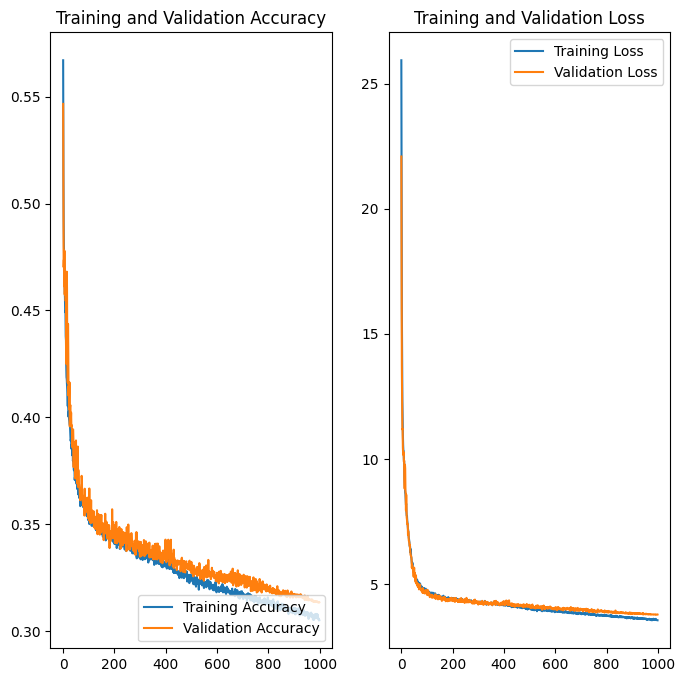

In [30]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

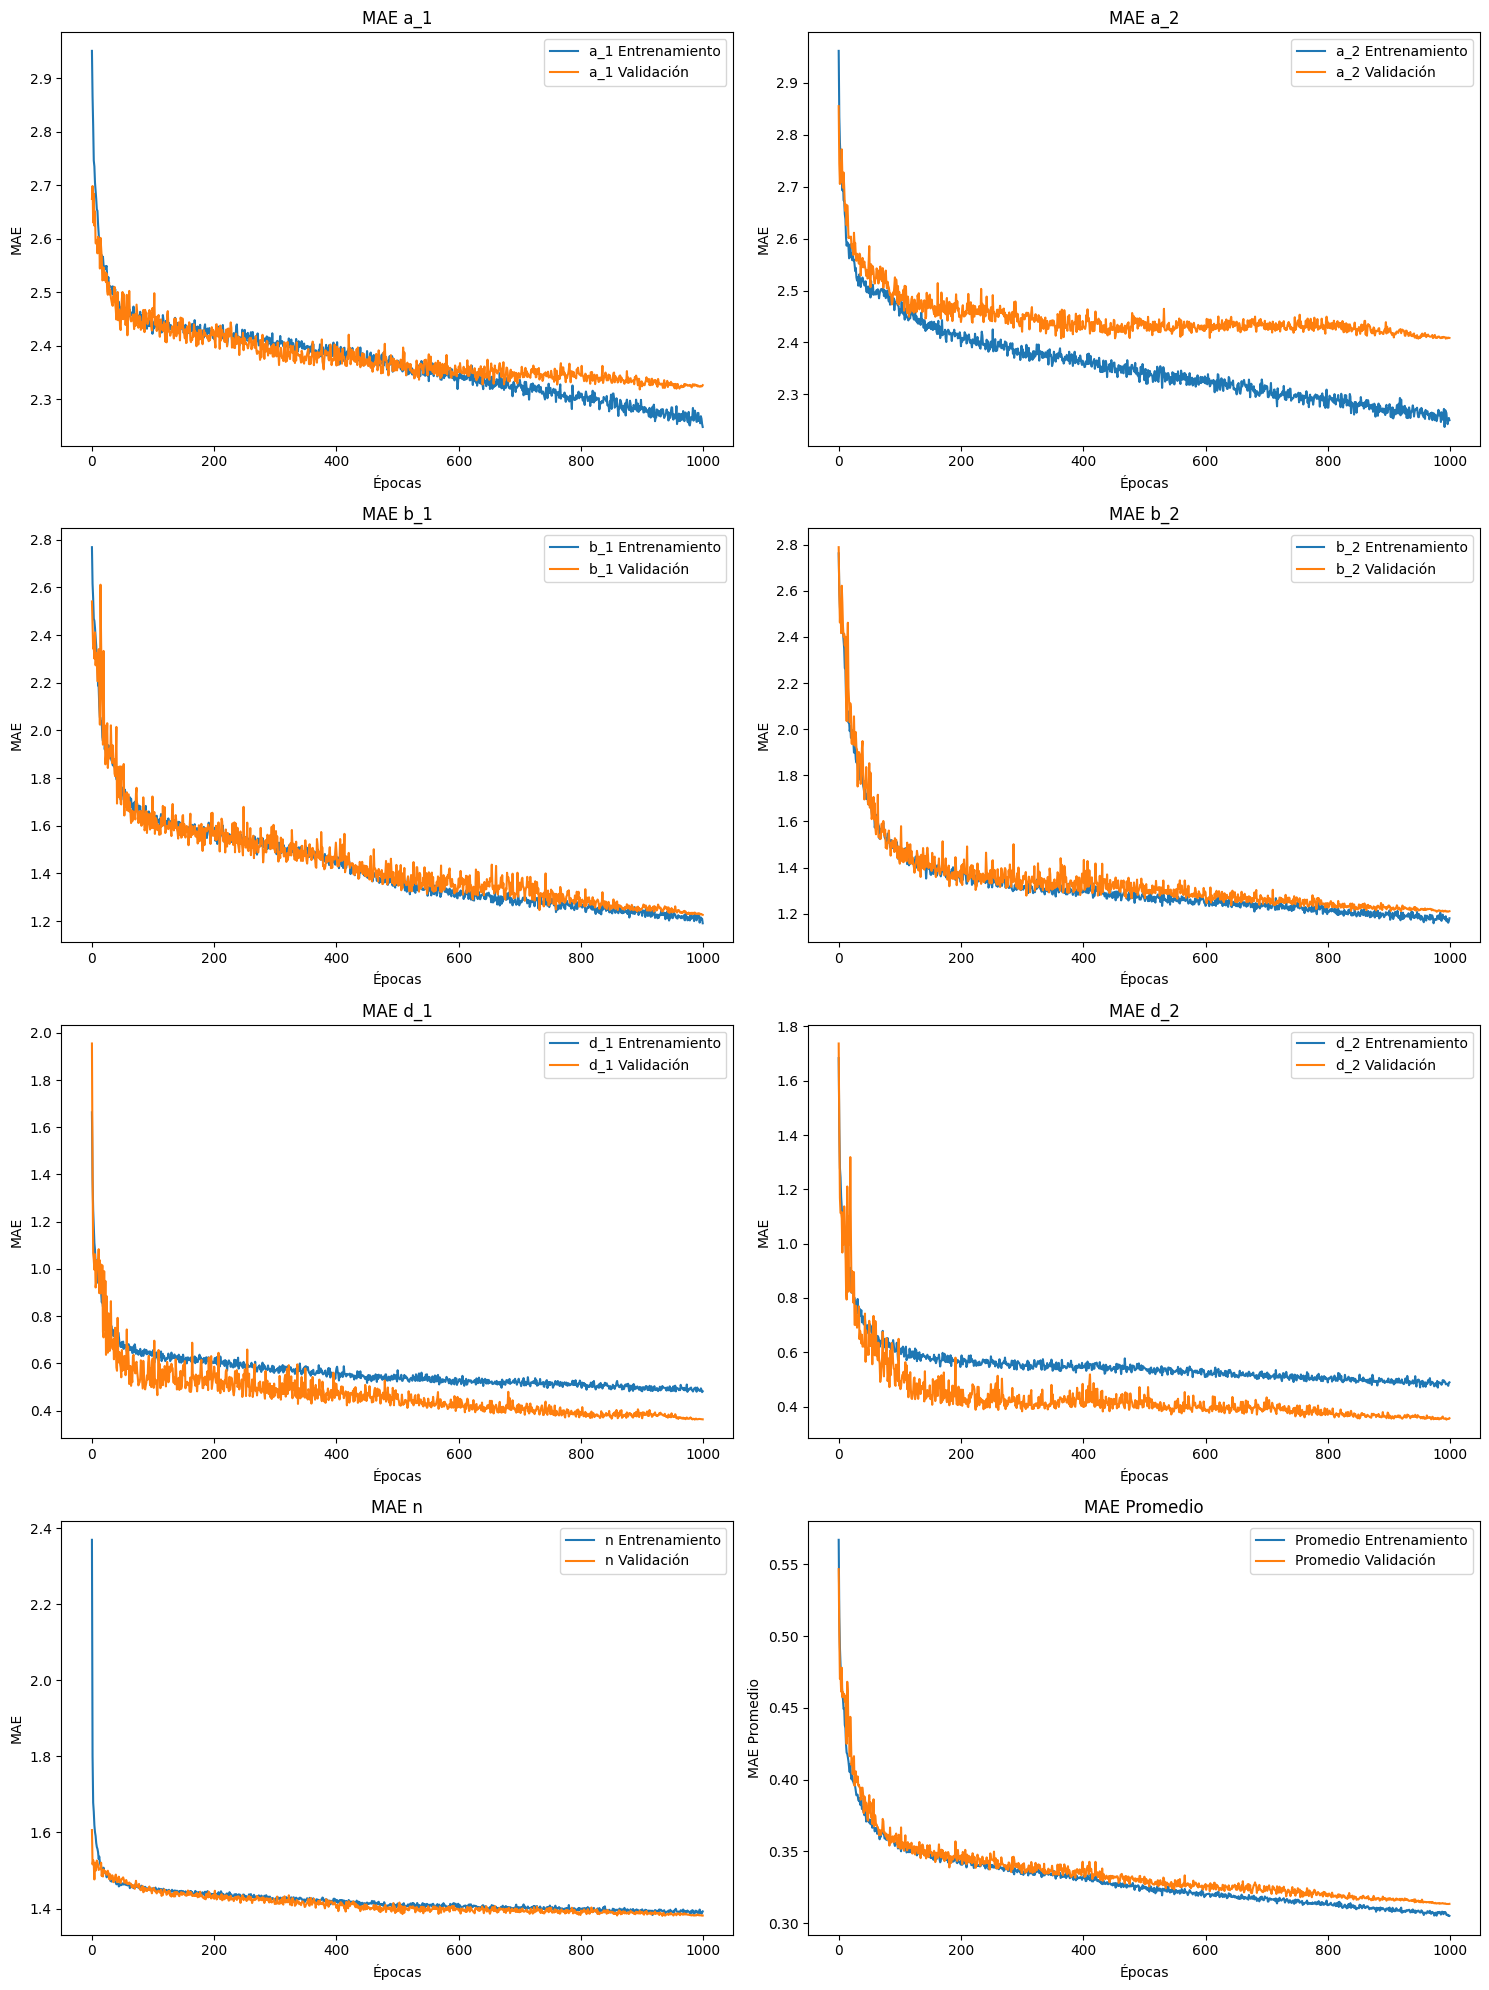

In [31]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [32]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    varftest, coefvarftest)

63/63 [==============================] - 0s 2ms/step - loss: 3.7434 - a_1: 2.3155 - a_2: 2.3422 - b_1: 1.2479 - b_2: 1.2005 - d_1: 0.3605 - d_2: 0.3645 - n: 1.3858 - mean_metric: 0.3079


In [33]:
predictions = model.predict(varftest)

63/63 [==============================] - 0s 1ms/step


In [34]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarftest, predictions)

# Calcula la desviación estándar del error
error = coefvarftest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.3168555295151558, Desviación estándar del error: 1.85599806366979, Error absoluto máximo: 7.797956228256226


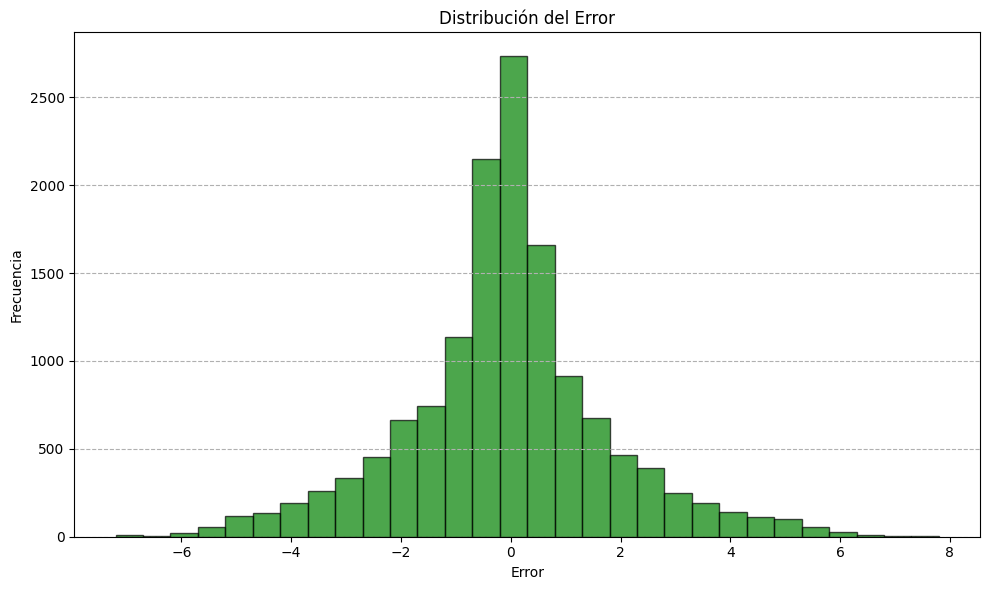

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [36]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefvarftest - predictions)

# Calcula el error para cada dato
error = coefvarftest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefvarftest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")

MAE relativo: 0.30966687683069444
Desviación estándar del error relativo: 0.1671851831974042
Error absoluto máximo relativo: 1.259341487288475


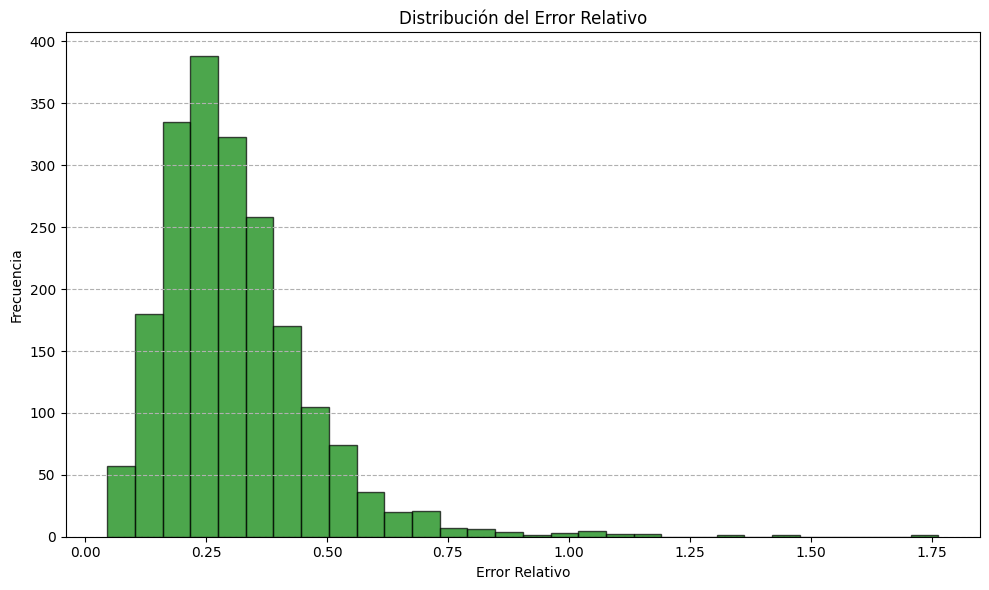

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos de Accuracy y Loss

In [38]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales con ruido/History 100,200/historytrayec200.csv', index=False)

# Guardamos el modelo

In [39]:
path_to_save = '../../../Modelos con ruido/Modelos 100,200'

In [40]:
model.save(path_to_save + '/trayectorias200.h5')

# Importamos el modelo

In [41]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [42]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [43]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/trayectorias200.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [41]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
T = 5
t_span = [0,5]
dt = 0.025
N = int(T/dt)

for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 200)
    
    varfci2 = []
    for i_ci in range(10):
        # Definimos las condiciones iniciales
        X = np.zeros(N)
        Y = np.zeros(N)
        X[0] = random.randint(0, 10)
        Y[0] = random.randint(0, 10)
        y0 = np.array([X[0], Y[0]])
        condini.append(y0)

        # Simulación con ruido
        for i in range(N-1):
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            X[i+1] = X[i] + (a1/(1+Y[i]**n) - d1*X[i] + b1)*dt + noise1*np.sqrt(dt)
            Y[i+1] = Y[i] + (a2/(1+X[i]**n) - d2*Y[i] + b2)*dt + noise2*np.sqrt(dt)


        varfci = np.append([X], [Y], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[1, 2, 4, 5, 1, 9, 0]
(10, 2, 200)


In [44]:
varfnone = varf[None, :]

## Predecimos con los datos nuevos

In [45]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 52ms/step
[[5. 2. 6. 1. 2. 9. 2.]]


## Graficamos con los coeficientes reales

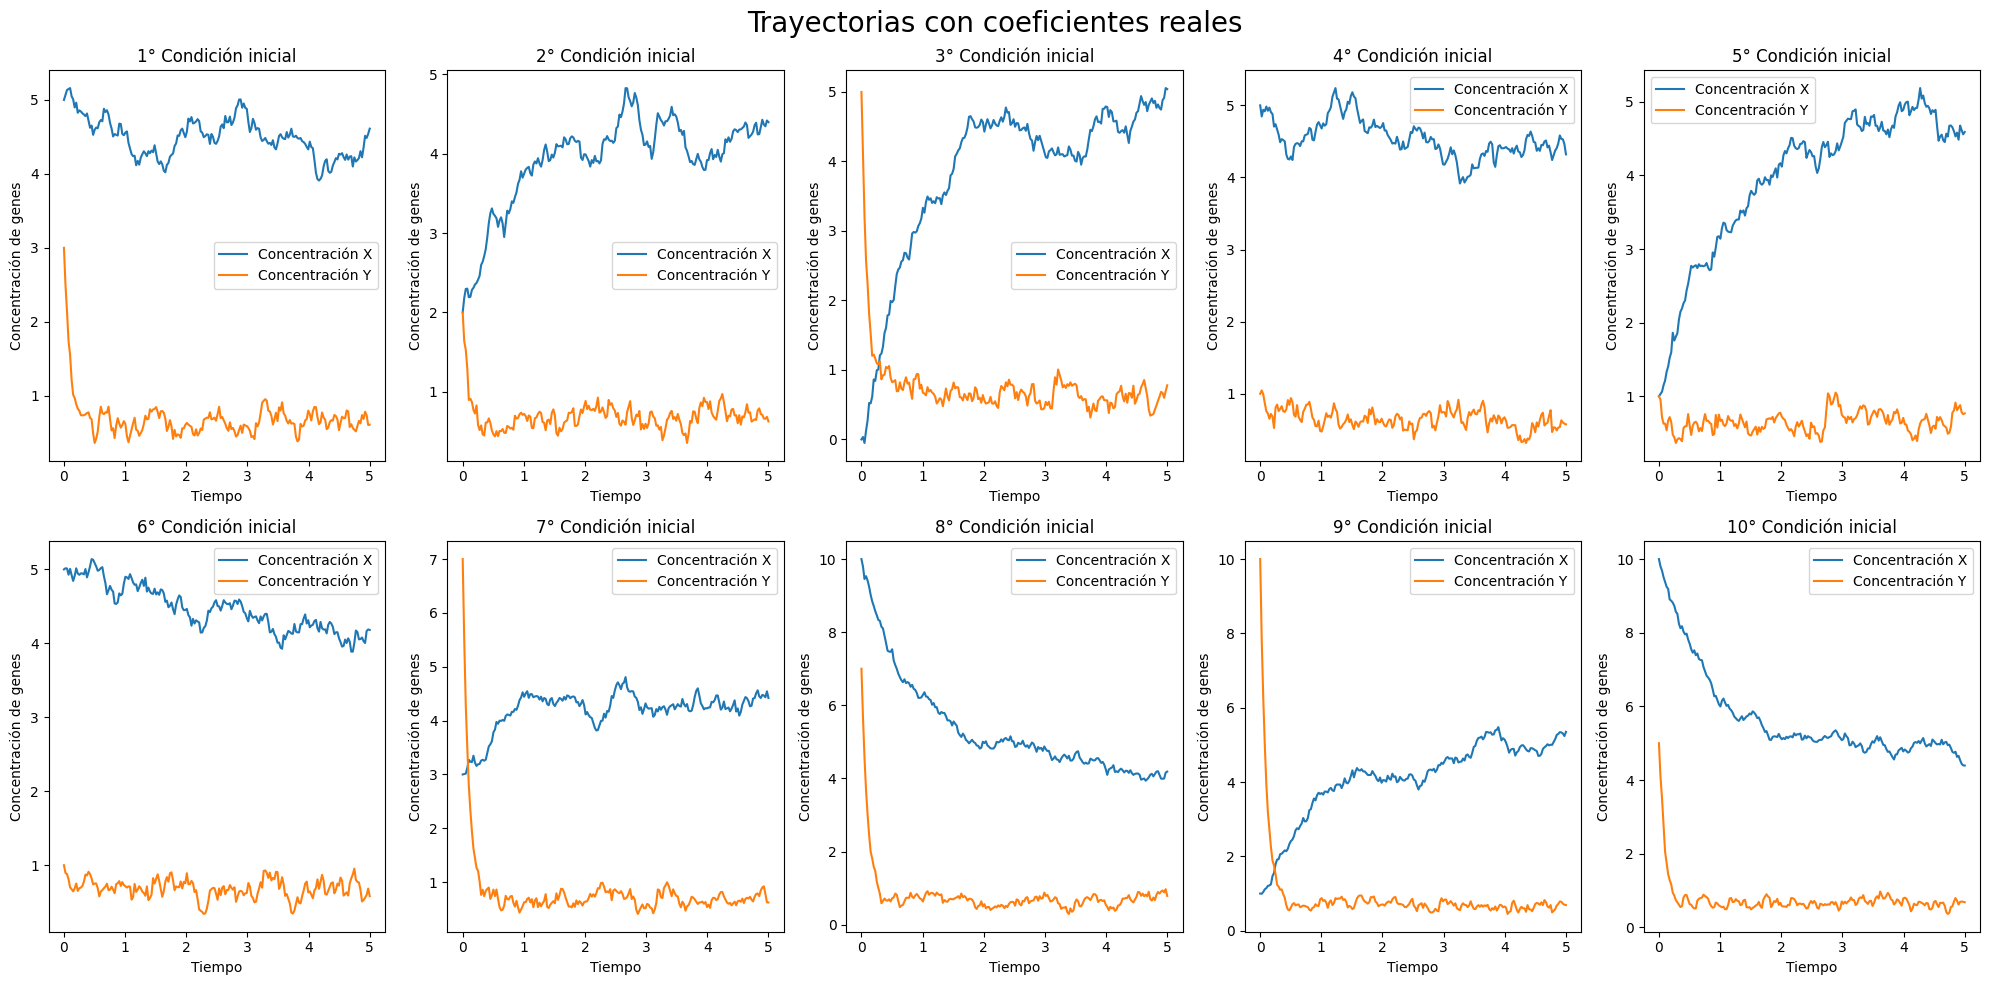

In [46]:
import matplotlib.pyplot as plt

t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos con los coeficientes predecidos

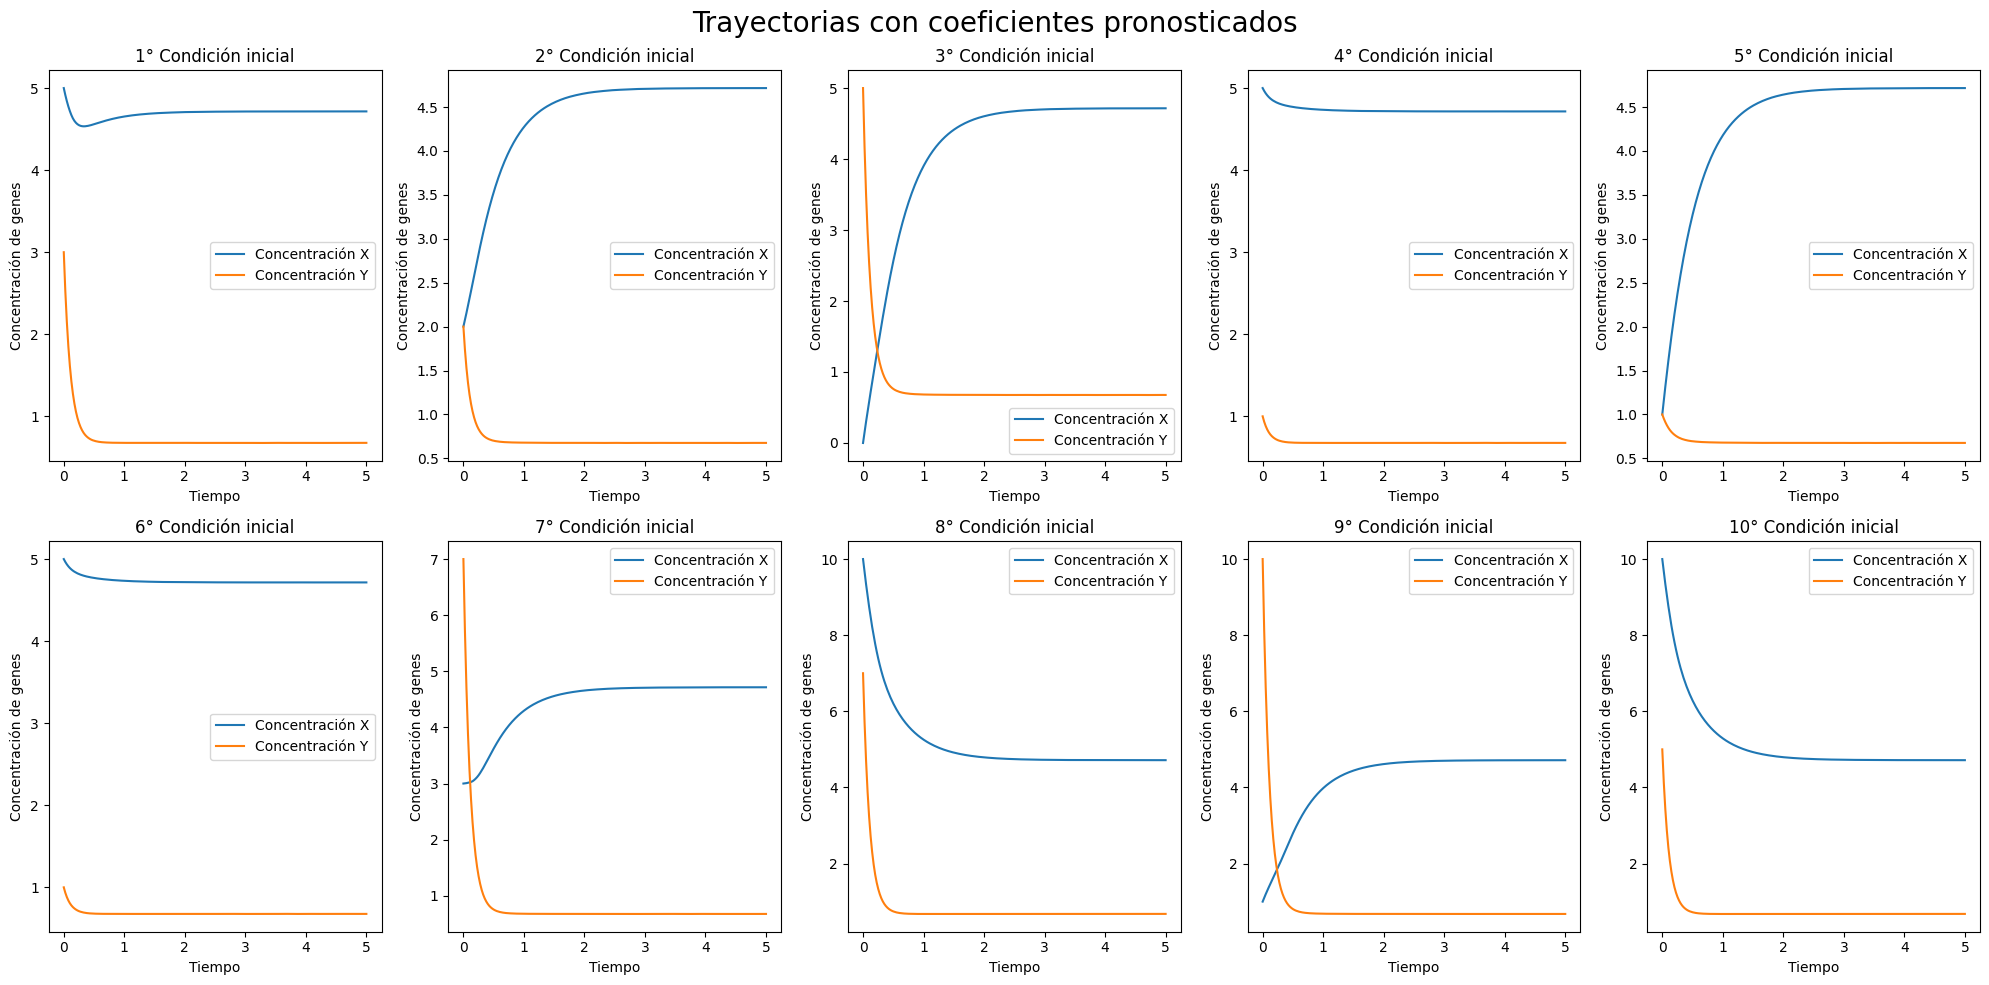

In [47]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

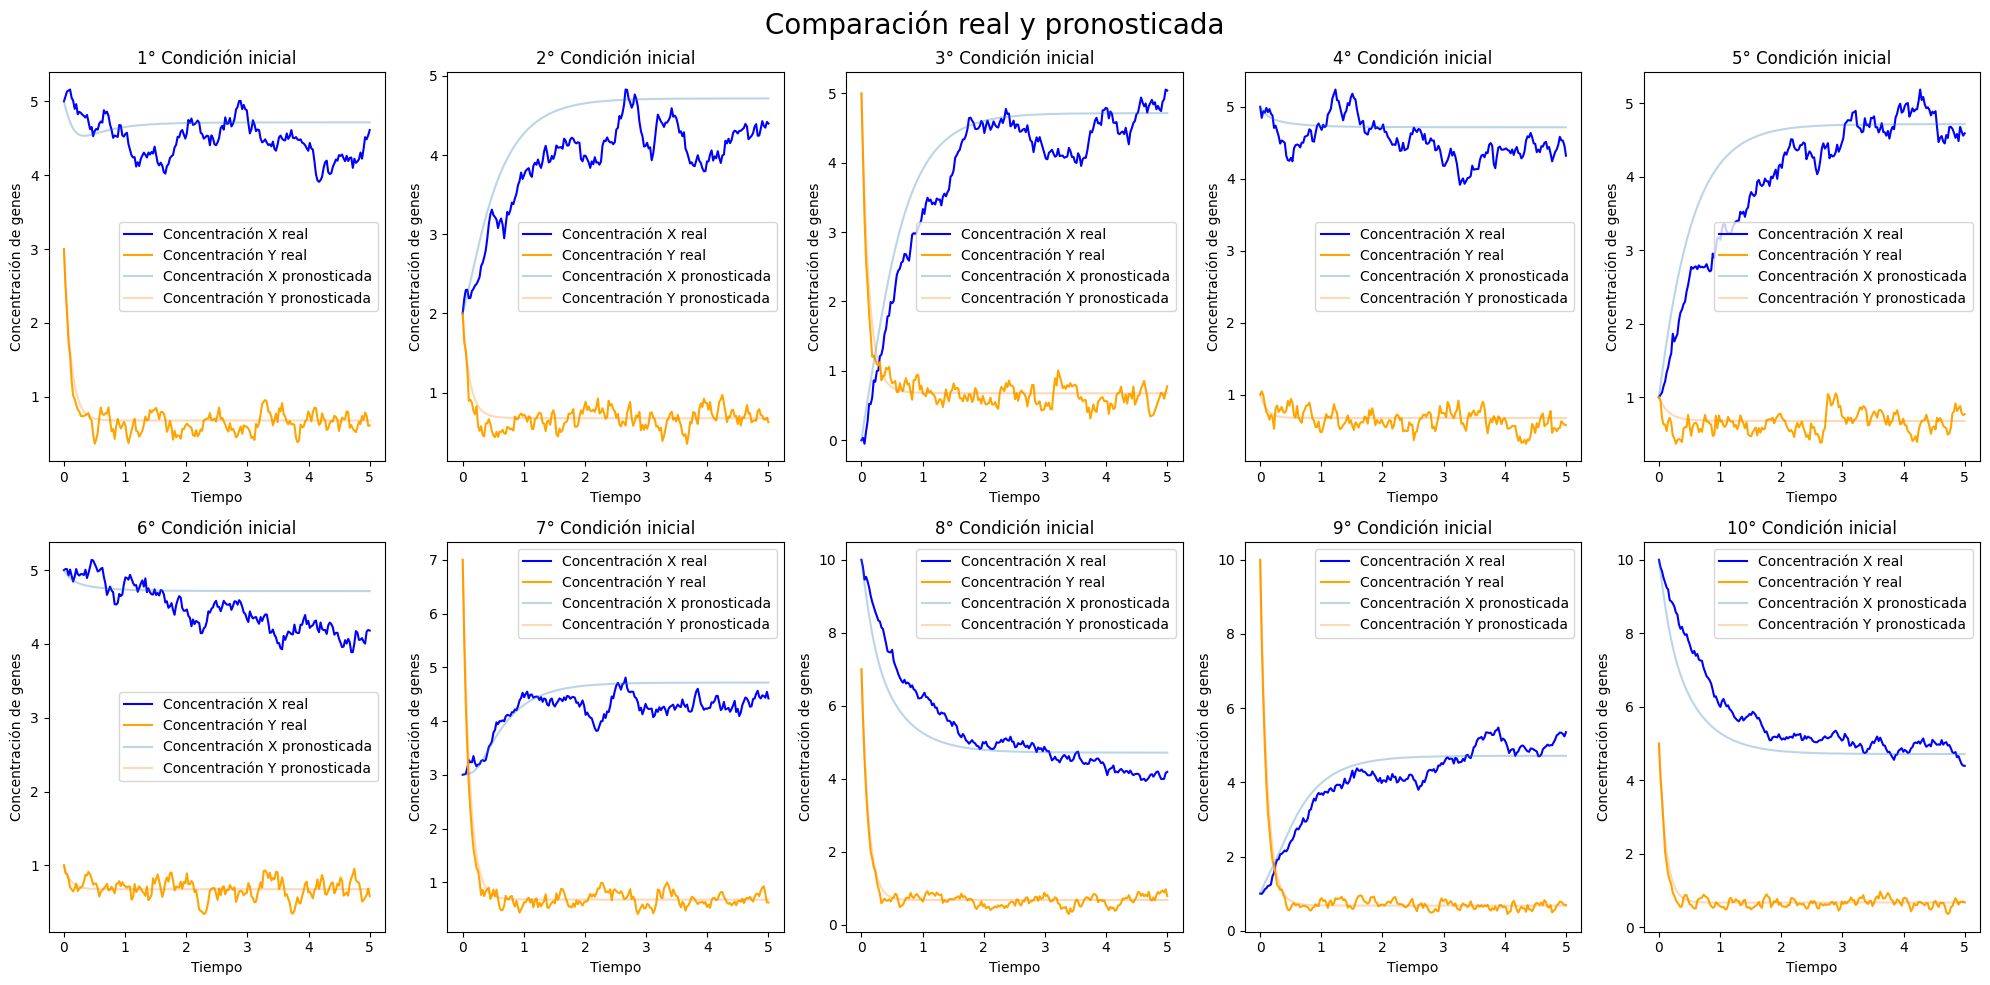

In [48]:
%matplotlib inline
#%matplotlib qt
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

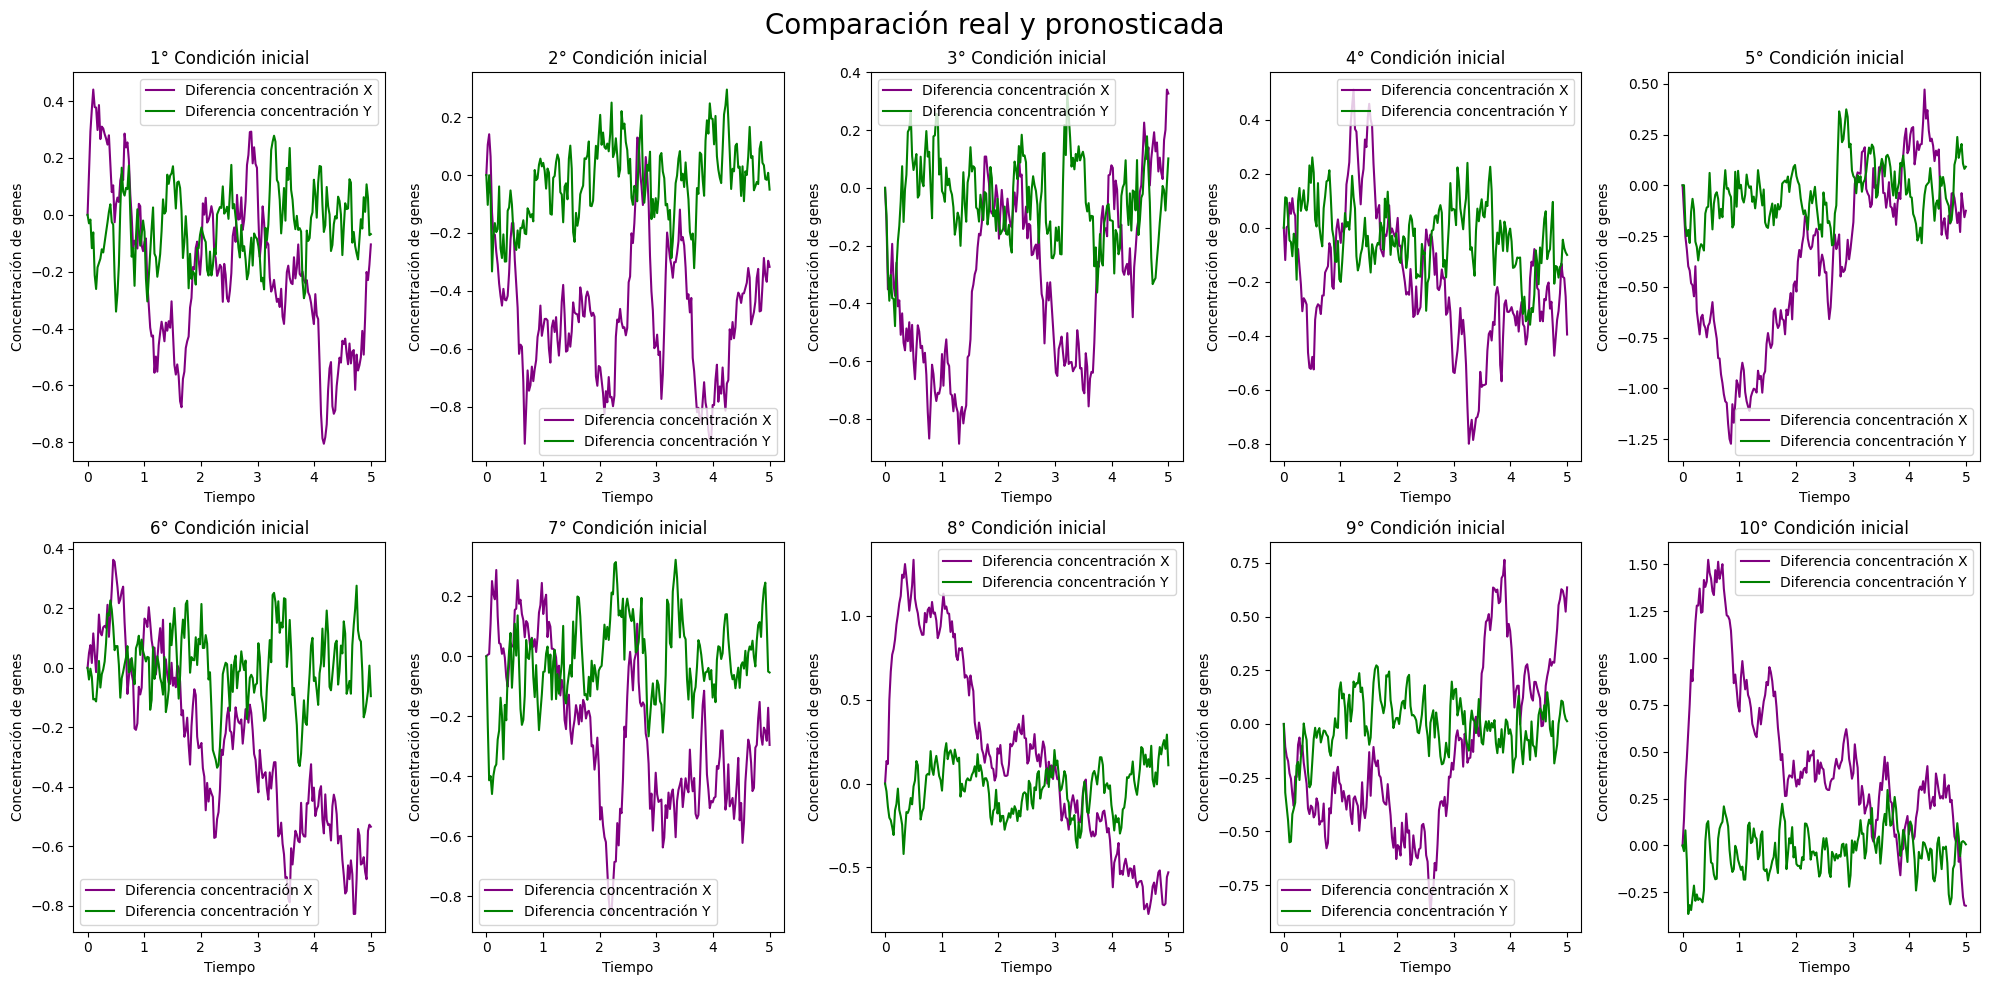

In [49]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [50]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.3819919957803161
0.10752352758192019
